# CS4035 - Cyber Data Analytics
## Lab 2 

In [1]:
# If this cell does not work try running `pip install nbformat`

import io
from IPython import nbformat

nb = nbformat.read("Lab2-Group69-Full.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\IPython\nbformat.py:12: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  warn("The `IPython.nbformat` package has been deprecated since IPython 4.0. "


Word count: 1580


- Word count for Visualization (group): 206

- Word count for LOF (Srinath): 528

- Word count for PCA (Andrew): 332

- Word count for ARMA (Andrew): 340

- Word count for Ngram (Srinath): N/A

- Word count for Comparison (group): 416

## Group Number: 69

## Student 1 
### Name : Andrew Gold
### ID : 4995902

## Student 2
### Name: Srinath Jayaraman
### ID: 5049903

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

1. Install the packages below
2. We have submitted individual assignments separately. **This notebook contains the entirety of our combined work, because training the models takes enormous amounts of time. !!! DO NOT RUN THIS NOTEBOOK !!!**
    - See the individual notebooks for implementations
    - This notebook exists just so you can see the visuals at the end. Training LOF/Ngram/ARMA will take hours.

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder, Normalizer, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

from mpl_toolkits.mplot3d import Axes3D


In [3]:
# df_train = pd.read_pickle('./SWaT_train.pkl')
# df_test = pd.read_pickle('./SWaT_test.pkl')

df_train = pd.read_csv('./SWaT_train.csv')
df_test = pd.read_csv('./SWaT_test.csv')


df_train = df_train.rename(columns={'Normal/Attack' : 'Label'})
df_test = df_test.rename(columns={'Normal/Attack' : 'Label'})

df_test.drop('Unnamed: 0', axis=1, inplace=True)


In [4]:
# Just drop Timestamp for now
df_train.drop(' Timestamp', axis=1, inplace=True)
df_test.drop(' Timestamp', axis=1, inplace=True)

In [5]:
df_train.rename(columns=lambda x: x.strip(), inplace=True)
df_test.rename(columns=lambda x: x.strip(), inplace=True)

In [6]:
df_train_x = df_train.drop('Label', axis=1, inplace=False)
df_test_x = df_test.drop('Label', axis=1, inplace=False)


df_train_y = pd.Series(LabelEncoder().fit_transform(df_train.Label).astype('int8'))
df_test_y = pd.Series(LabelEncoder().fit_transform(df_test.Label).astype('int8'))

## 1. Familiarization task – 1 A4

### 1a. Plot visualizations 

Let's first look at both whole datasets:

Text(0.5, 1.0, 'Training Data')

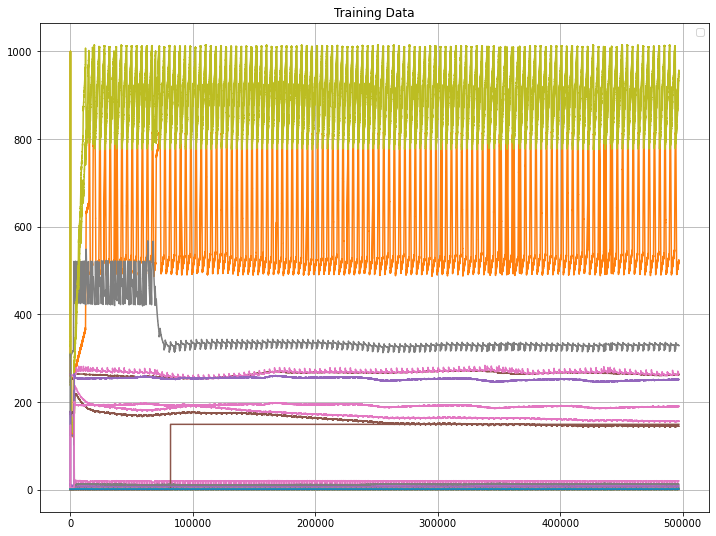

In [7]:
fig = plt.figure(figsize=(12,9))
plt.legend(df_train_x.columns)
plt.grid()


# Let's just look at everything lumped together for a second
for col in df_train_x.columns:
    plt.plot(df_train_x[col])
    
plt.title("Training Data")

Text(0.5, 1.0, 'Testing Data')

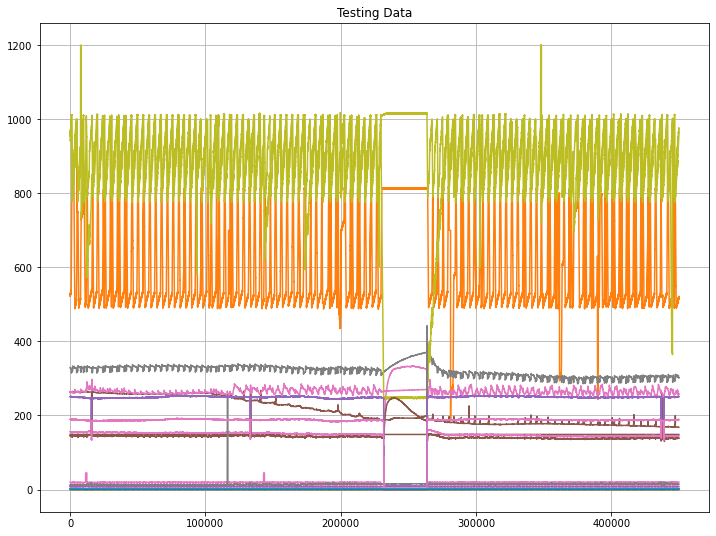

In [8]:
fig = plt.figure(figsize=(12,9))
plt.grid()

for col in df_test_x.columns:
    plt.plot(df_test_x[col])
    
plt.title("Testing Data")

**We can see above that there's 3 "bands" of signals: One with very low values (less than 100), one with middle-range values (between 100 and 400), and high values (above 400). Let's split these into 3 groups:**

In [9]:
lower_band = []
for col in df_train_x.columns:

    if np.max(df_train_x[col].iloc[100000:200000] < 100) and col != "AIT401":
#         print(col, np.max(df_train_x[col].iloc[50000:100000]))
        lower_band.append(col)
lower_band

['FIT101',
 'MV101',
 'P101',
 'P102',
 'AIT202',
 'FIT201',
 'MV201',
 'P201',
 'P202',
 'P203',
 'P204',
 'P205',
 'P206',
 'DPIT301',
 'FIT301',
 'MV301',
 'MV302',
 'MV303',
 'MV304',
 'P301',
 'P302',
 'FIT401',
 'P401',
 'P402',
 'P403',
 'P404',
 'UV401',
 'AIT501',
 'AIT504',
 'FIT501',
 'FIT502',
 'FIT503',
 'FIT504',
 'P501',
 'P502',
 'PIT502',
 'FIT601',
 'P601',
 'P602',
 'P603']

In [10]:
middle_band = []
for col in df_train_x.columns:
   
    if np.min(df_train_x[col].iloc[100000:200000] > 100) and np.max(df_train_x[col].iloc[100000:200000] < 400):
#         print(col, np.max(df_train_x[col].iloc[50000:100000]))
        middle_band.append(col)
        
middle_band.append('AIT401')       
middle_band

['AIT201',
 'AIT203',
 'AIT401',
 'AIT402',
 'AIT502',
 'AIT503',
 'PIT501',
 'PIT503',
 'AIT401']

In [11]:
upper_band = []
for col in df_train_x.columns:
   
    if np.min(df_train_x[col].iloc[100000:200000] > 400):
#         print(col, np.max(df_train_x[col].iloc[50000:100000]))
        upper_band.append(col)
        
upper_band

['LIT101', 'LIT301', 'LIT401']

## 1b. Answers to the three questions

### (1) **What kind of signals are there? Show 3 examples:**

Plot each band of signals separately:

Text(0.5, 1.0, 'Lower Band')

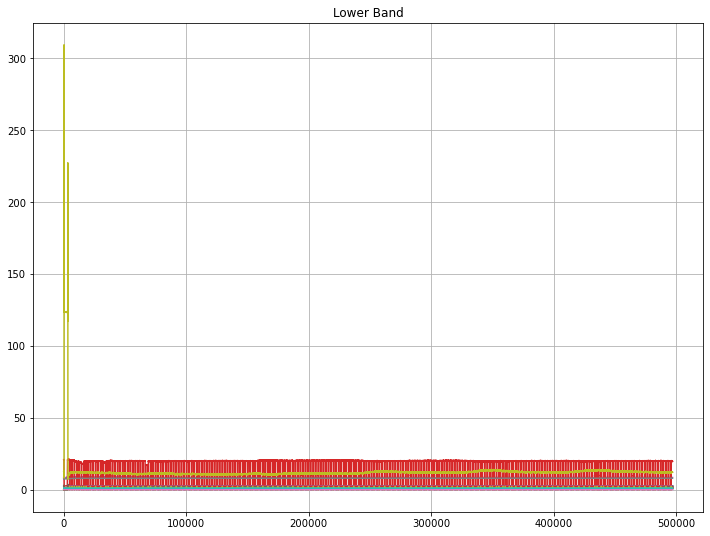

In [12]:
fig = plt.figure(figsize=(12,9))
plt.grid()

for col in df_train_x[lower_band]:
    plt.plot(df_train_x[col])
    
plt.title("Lower Band")

Text(0.5, 1.0, 'Middle Band')

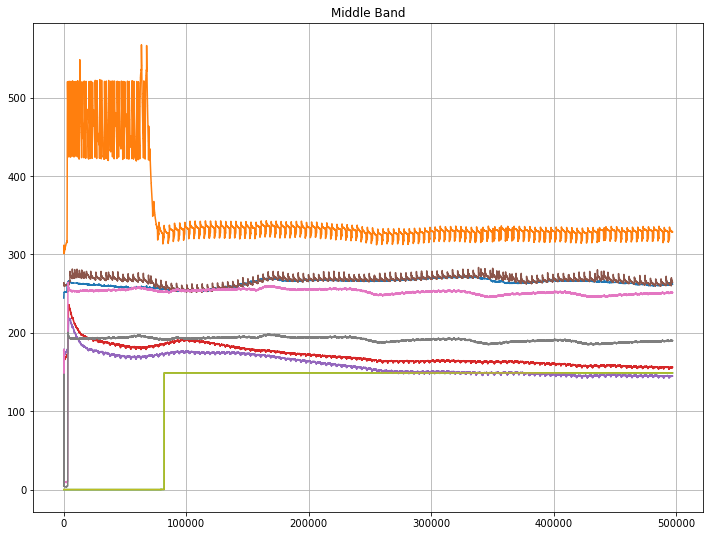

In [13]:
fig = plt.figure(figsize=(12,9))
plt.grid()

for col in df_train_x[middle_band]:
    plt.plot(df_train_x[col])
    
plt.title("Middle Band")

Text(0.5, 1.0, 'Upper Band')

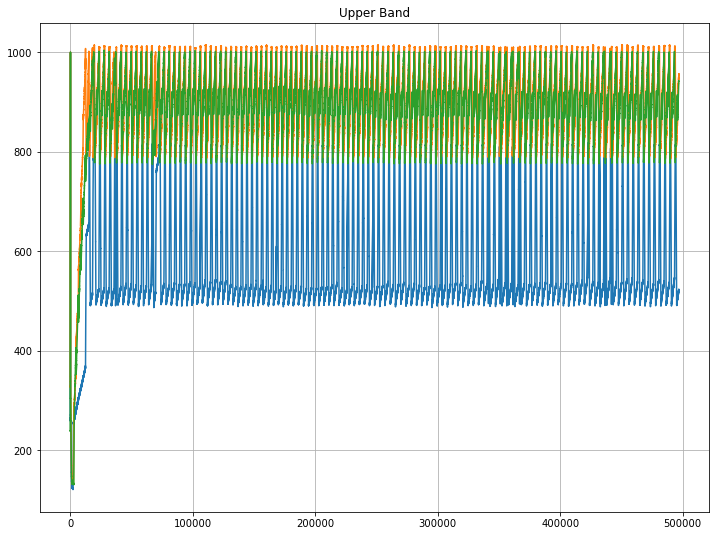

In [14]:
fig = plt.figure(figsize=(12,9))
plt.grid()

for col in df_train_x[upper_band]:
    plt.plot(df_train_x[col])
    
plt.title("Upper Band")

**We can see above that the startup phase of the system (according to the paper attached to the assignment) is the only major anomaly in the dataset. To be safe, let's drop the first 100k rows:**

Text(0.5, 1.0, 'Shortened Dataset (startup anomalies removed)')

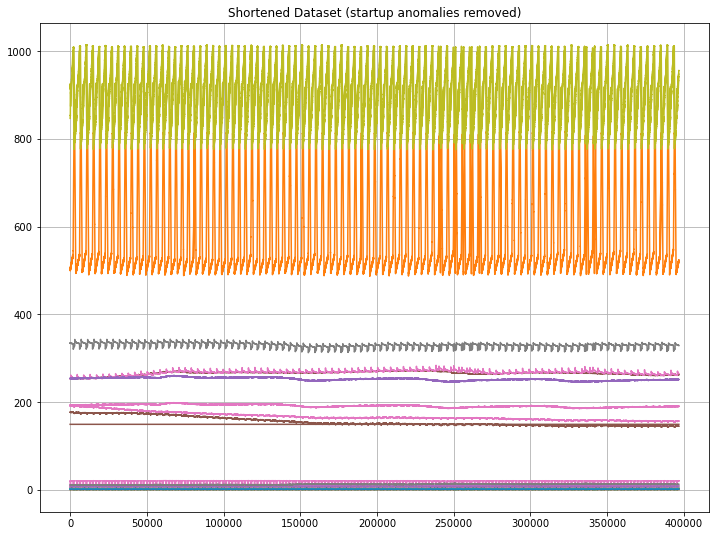

In [15]:
df_train_x_short = df_train_x.iloc[100000:].copy().reset_index(drop=True)

fig = plt.figure(figsize=(12,9))
plt.grid()

for col in df_train_x_short.columns:
    plt.plot(df_train_x_short[col])
    
plt.title("Shortened Dataset (startup anomalies removed)")

### (2) Are the signals clearly correlated?

As seen below, there are some attributes that are very closely correlated. Let's take a look at the overall correlation, as well as the correlation between each band of signals.

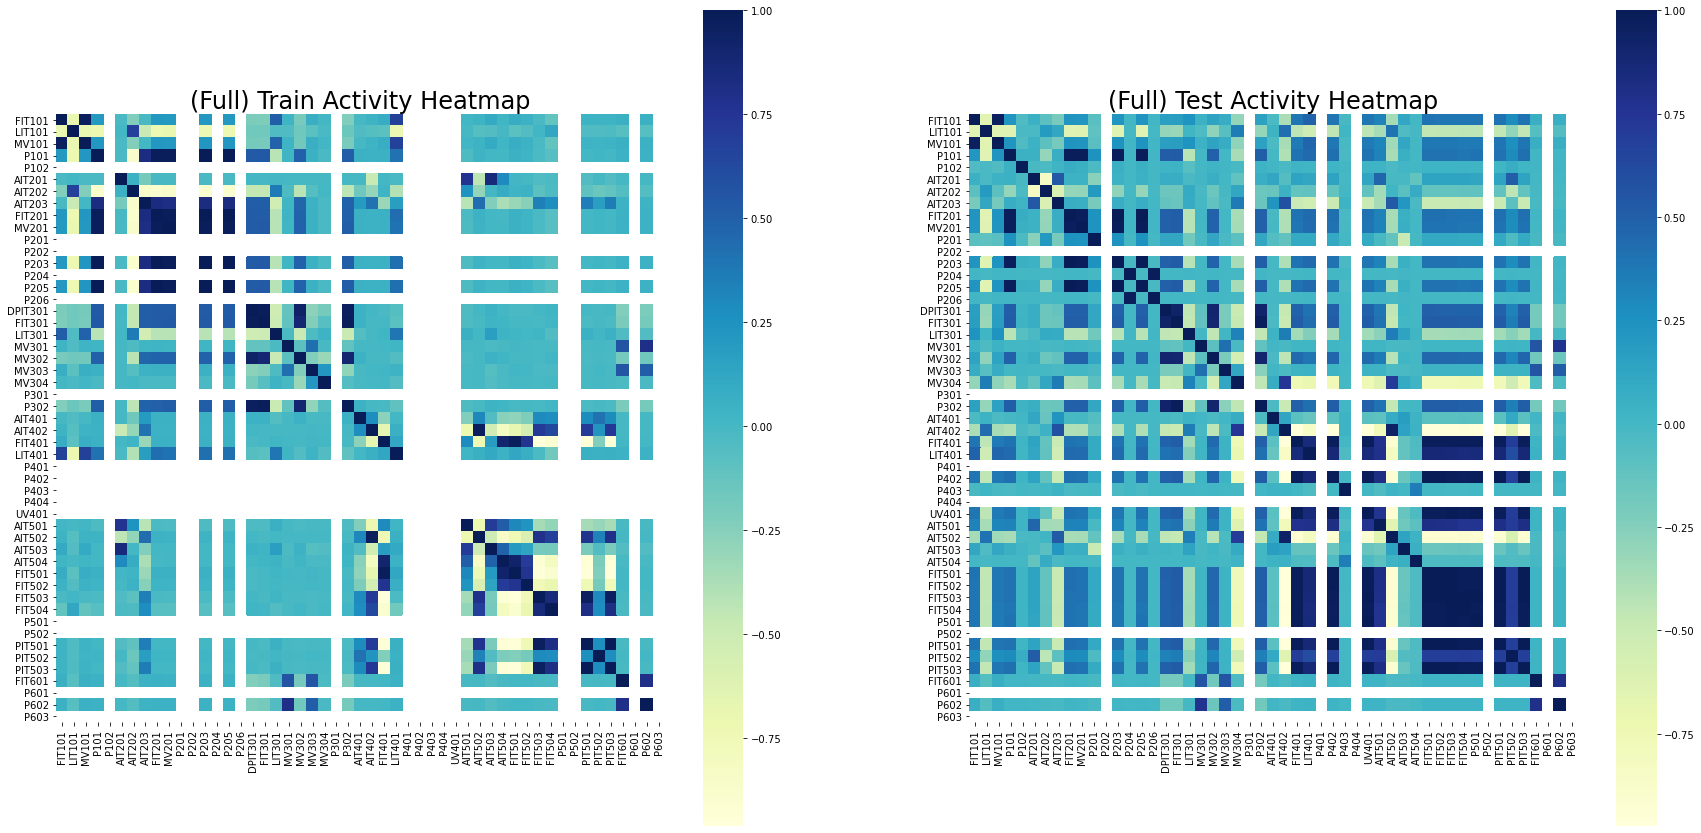

In [16]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(30, 15))


sns.heatmap(df_train_x_short.corr(), square=True, ax=ax1, cmap = 'YlGnBu', cbar=True)
ax1.set_title('(Full) Train Activity Heatmap', size=24)

sns.heatmap(df_test_x.corr(), square=True, ax=ax2, cmap = 'YlGnBu', cbar=True)
ax2.set_title('(Full) Test Activity Heatmap', size=24)

plt.show()

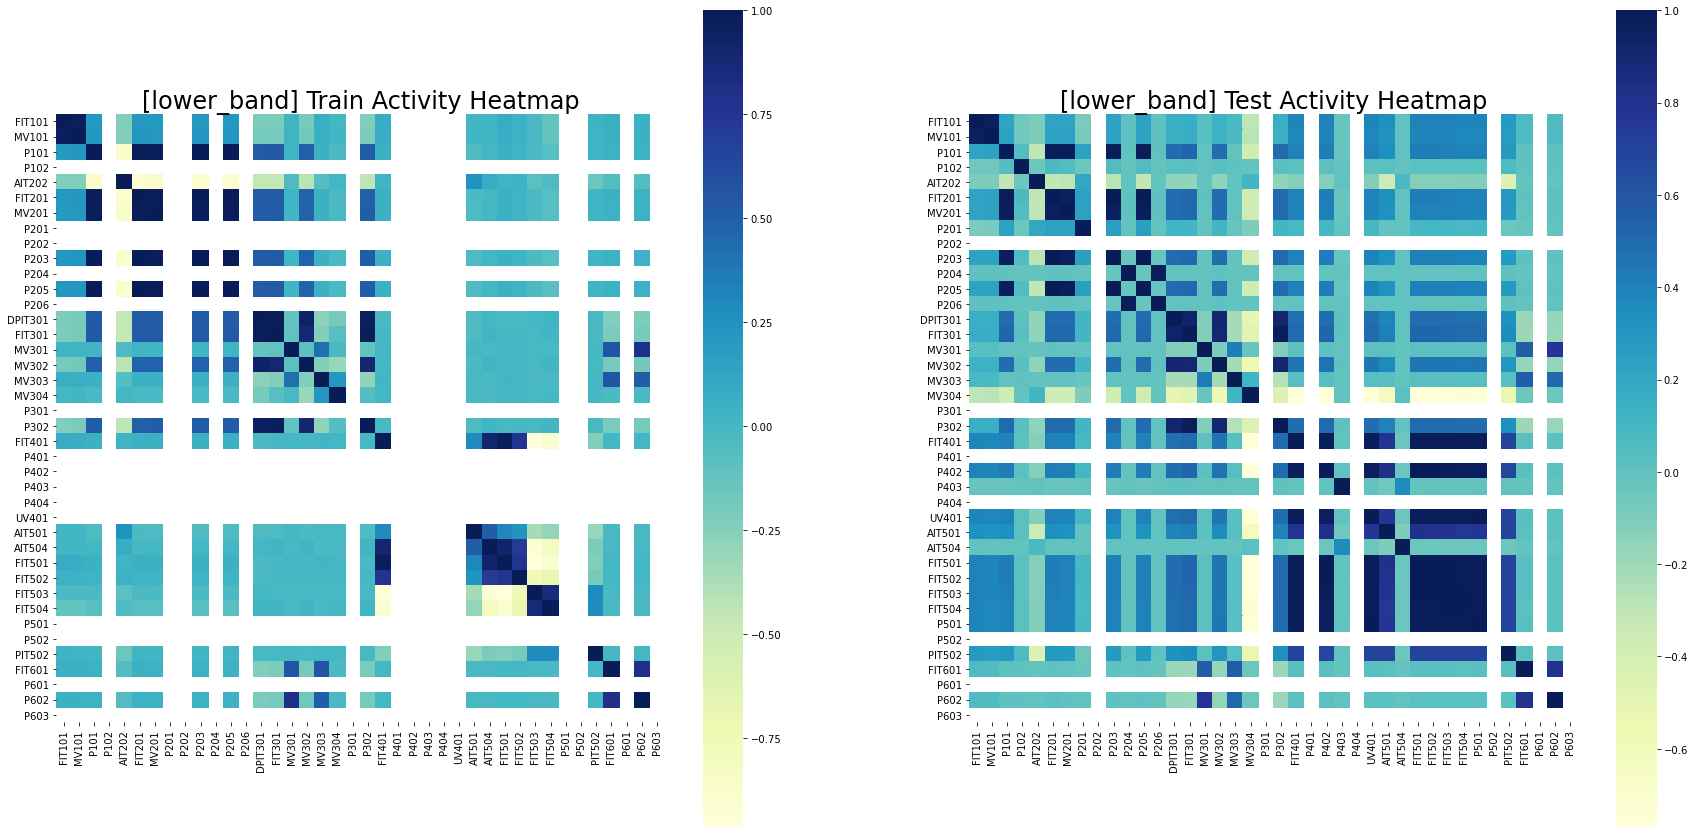

In [17]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(30, 15))


sns.heatmap(df_train_x_short[lower_band].corr(), square=True, ax=ax1, cmap = 'YlGnBu', cbar=True)
ax1.set_title('[lower_band] Train Activity Heatmap', size=24)

sns.heatmap(df_test_x[lower_band].corr(), square=True, ax=ax2, cmap = 'YlGnBu', cbar=True)
ax2.set_title('[lower_band] Test Activity Heatmap', size=24)

plt.show()

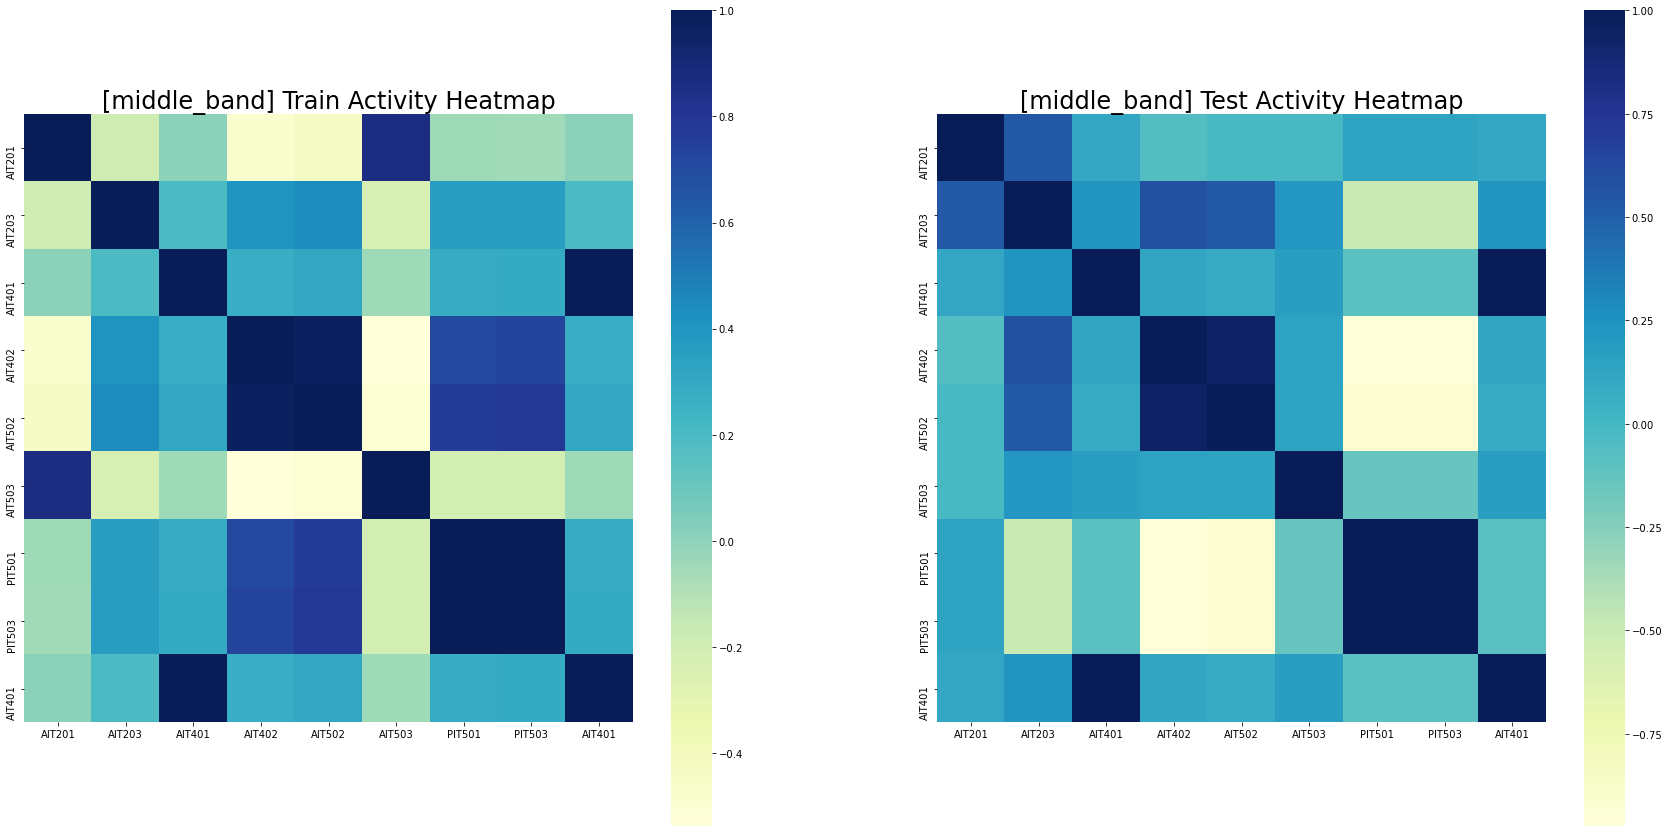

In [18]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(30, 15))


sns.heatmap(df_train_x_short[middle_band].corr(), square=True, ax=ax1, cmap = 'YlGnBu', cbar=True)
ax1.set_title('[middle_band] Train Activity Heatmap', size=24)

sns.heatmap(df_test_x[middle_band].corr(), square=True, ax=ax2, cmap = 'YlGnBu', cbar=True)
ax2.set_title('[middle_band] Test Activity Heatmap', size=24)

plt.show()

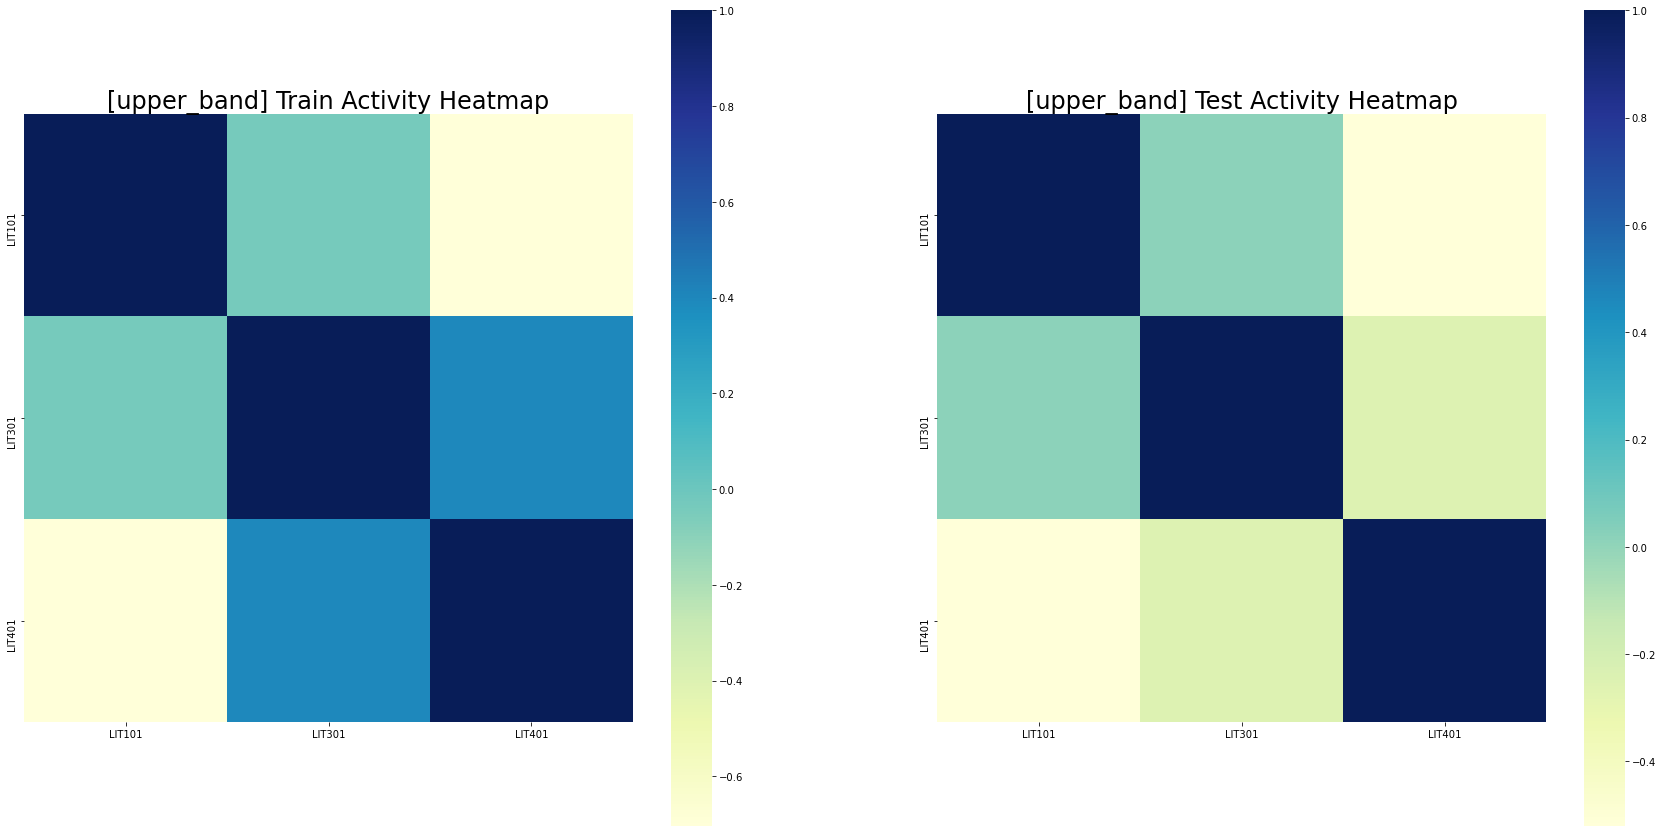

In [19]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(30, 15))


sns.heatmap(df_train_x_short[upper_band].corr(), square=True, ax=ax1, cmap = 'YlGnBu', cbar=True)
ax1.set_title('[upper_band] Train Activity Heatmap', size=24)

sns.heatmap(df_test_x[upper_band].corr(), square=True, ax=ax2, cmap = 'YlGnBu', cbar=True)
ax2.set_title('[upper_band] Test Activity Heatmap', size=24)

plt.show()

We know from the dataset description that many of these features are things like Flow Meters for a specific tank (FIT501 - FIT504), or dosing pumps for various minerals (P201 - P206). Therefore, it's very reasonable to see this high degree of correlation between certain features. However, when looking at the dataset as a whole, if we see high degrees of correlation in the testing data between unrelated features, that might be something worth investigating.

### (3) Do they show cyclic behavior? If so, show an example of when this happens:

Yes, all of the signals are cyclical in their own way. See below for a single example:

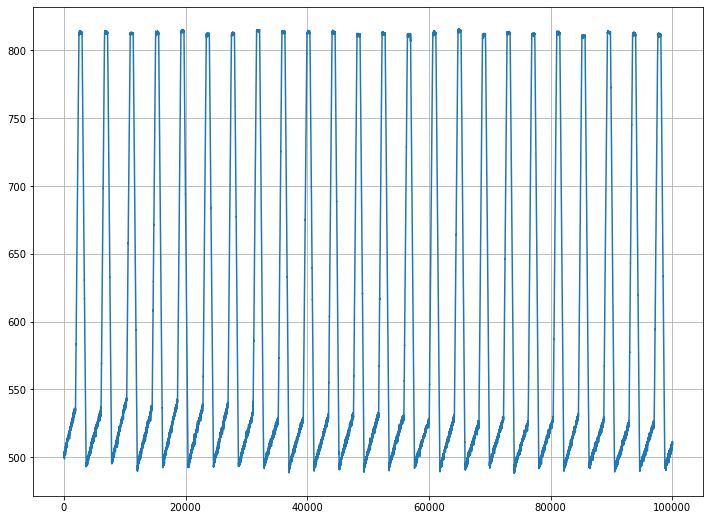

In [20]:
fig = plt.figure(figsize=(12,9))
plt.grid()

plt.plot(df_train_x_short.LIT101[:100000])

## 2. LOF task – 1/2 A4 – Individual

### 2a. Plot LOF scores

### 2b. Analysis and answers to the questions

## 3. PCA task – 1/2 A4 – Individual

### 3a. Plot PCA residuals

In [21]:
# with_std = False because I don't want to scale the data to unit variance
df_train_x_norm = pd.DataFrame(StandardScaler(with_std=False).fit_transform(df_train_x_short), columns=df_train_x_short.columns)
df_test_x_norm = pd.DataFrame(StandardScaler(with_std=False).fit_transform(df_test_x), columns=df_train_x.columns)

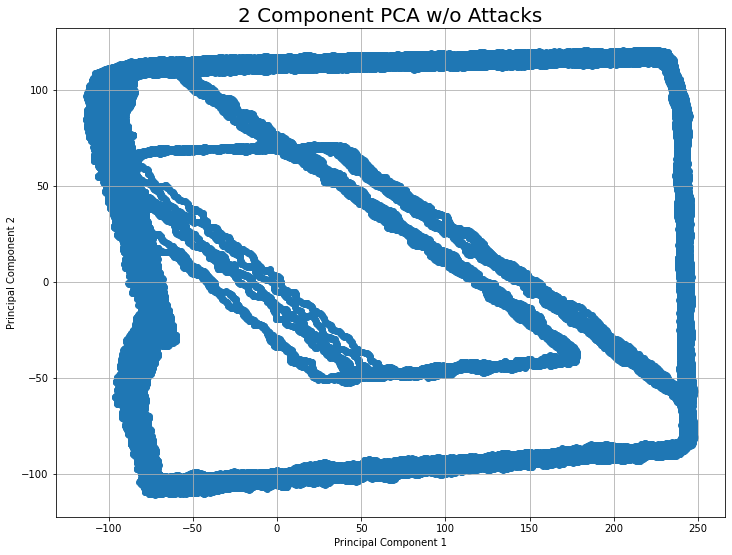

In [22]:
# Set the number of components = 2, and fit/transform the (normalized) data
PCA_2c = PCA(n_components=2)
df_pca_2c = pd.DataFrame(PCA_2c.fit_transform(df_train_x_norm), columns = ['PC_1', 'PC_2'])

fig, (ax) = plt.subplots(1, figsize=(12,9))

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2 Component PCA w/o Attacks', fontsize = 20)

ax.scatter(df_pca_2c.PC_1, df_pca_2c.PC_2)
ax.grid()

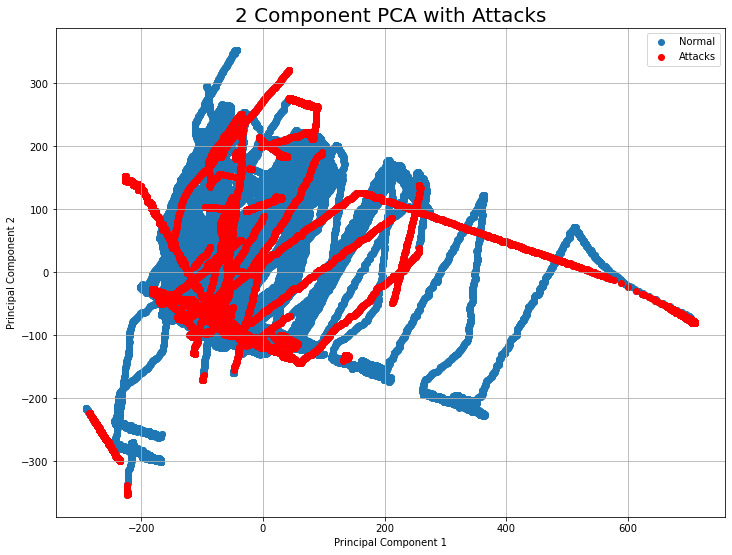

In [23]:
# Set the number of components = 2, and fit/transform the (normalized) data
PCA_2c_test = PCA(n_components=2)
df_pca_2c_test = pd.DataFrame(PCA_2c_test.fit_transform(df_test_x_norm), columns = ['PC_1', 'PC_2'])

fig, (ax) = plt.subplots(1, figsize=(12,9))

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2 Component PCA with Attacks', fontsize = 20)

ax.scatter(df_pca_2c_test.PC_1, df_pca_2c_test.PC_2)
ax.scatter(df_pca_2c_test.PC_1.loc[np.where(df_test_y == 0)], df_pca_2c_test.PC_2.loc[np.where(df_test_y == 0)], color='r')

plt.legend(['Normal', 'Attacks'])

ax.grid()

Let's look to see how much of the training data's variance is explained by the first 2 principal components:

In [24]:
print("Explained variance (training data) for [PC1, PC2]:", PCA_2c.explained_variance_ratio_)
print("Explained variance (testing data) for [PC1, PC2]:", PCA_2c_test.explained_variance_ratio_)

Explained variance (training data) for [PC1, PC2]: [0.68594304 0.25297616]
Explained variance (testing data) for [PC1, PC2]: [0.70763667 0.159907  ]


Such a low explained variance ratio means that there's a lot of variance throughout the data. More principal components could lead to a better outcome. However, for visualization purposes, it's difficult to go higher than 3 dimensions. To preserve any higher variance we may need to increase the amount of dimensions. Let's focus on 3 dimensions.

In [25]:
# Intervals up to 95% variance, any higher might result in overfitting
intervals = [0.50, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]

for i in intervals:
    pca_test = PCA().fit(df_train_x_norm)
    cumulative_sum = np.cumsum(pca_test.explained_variance_ratio_)
    dim = np.argmax(cumulative_sum > i) + 1
    print("Number of principal components required to preserve", i * 100, "% variance in the data:", dim) 

Number of principal components required to preserve 50.0 % variance in the data: 1
Number of principal components required to preserve 60.0 % variance in the data: 1
Number of principal components required to preserve 65.0 % variance in the data: 1
Number of principal components required to preserve 70.0 % variance in the data: 2
Number of principal components required to preserve 75.0 % variance in the data: 2
Number of principal components required to preserve 80.0 % variance in the data: 2
Number of principal components required to preserve 85.0 % variance in the data: 2
Number of principal components required to preserve 90.0 % variance in the data: 2
Number of principal components required to preserve 95.0 % variance in the data: 3


In [26]:
optimal_comp = dim

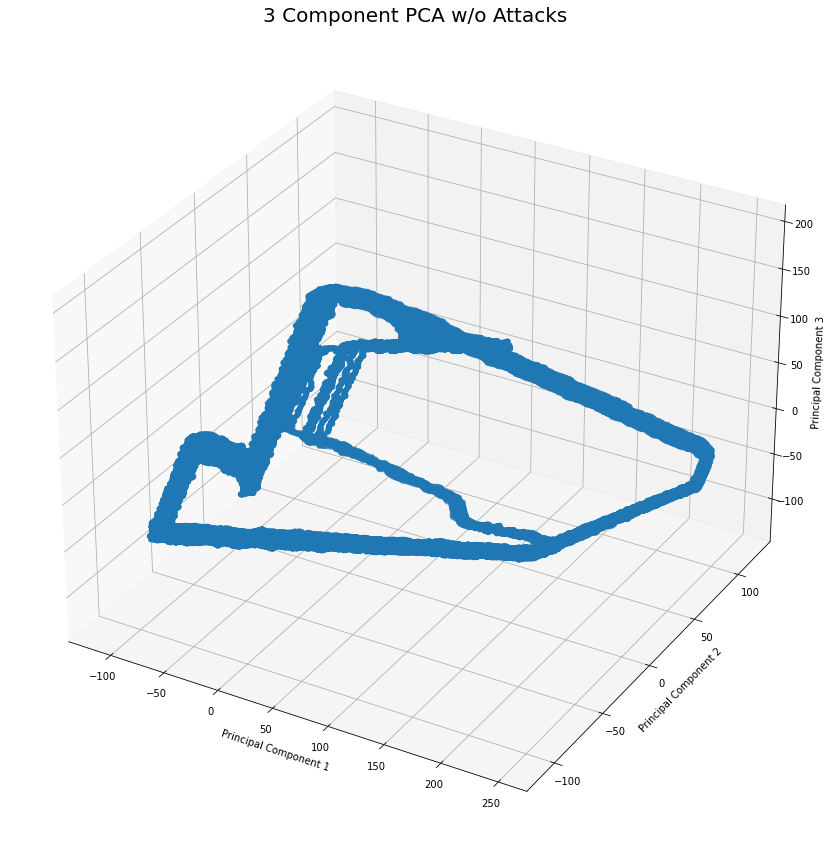

In [27]:
# 3 Dimensions for visualization

PCA_3c = PCA(n_components=3)
df_pca_3c = pd.DataFrame(PCA_3c.fit_transform(df_train_x_norm), columns = ['PC_1', 'PC_2', 'PC_3'])

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3 Component PCA w/o Attacks', fontsize = 20)

ax.scatter(df_pca_3c.PC_1, df_pca_3c.PC_2, df_pca_3c.PC_3)
ax.grid()
plt.show()

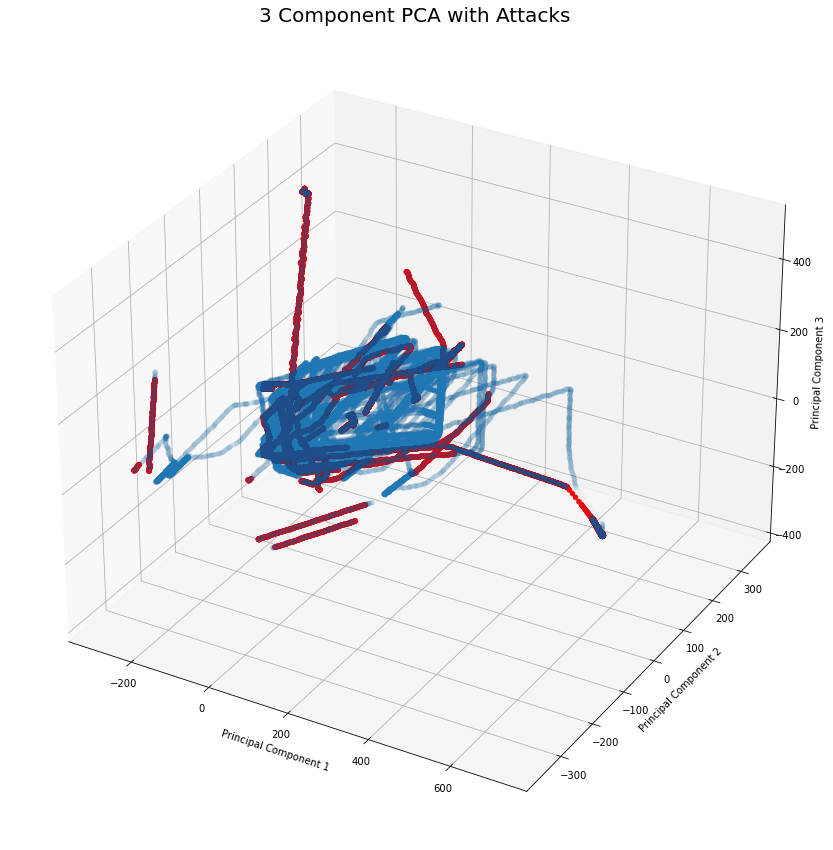

In [28]:
# Set the number of components = 3, and fit/transform the (normalized) data
df_pca_3c_test = pd.DataFrame(PCA_3c.fit_transform(df_test_x_norm), columns = ['PC_1', 'PC_2', 'PC_3'])

fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3 Component PCA with Attacks', fontsize = 20)


ax.scatter(df_pca_3c_test.PC_1, df_pca_3c_test.PC_2, df_pca_3c_test.PC_3, alpha=0.025, zorder=-1)
ax.scatter(df_pca_3c_test.PC_1.loc[np.where(df_test_y == 0)],
           df_pca_3c_test.PC_2.loc[np.where(df_test_y == 0)],
           df_pca_3c_test.PC_3.loc[np.where(df_test_y == 0)],
           color='r', alpha=1.0, zorder=1)



ax.grid()
plt.show()


### Threshold
With PCA anomaly detection, we need some way to score examples such that anomalies stand out. I'll use the reconstruction error in this assignment. The following method is taken from the excellent O'Reilly book *Hands-on Unsupervised Learning* by Ankur A. Patel: https://www.oreilly.com/library/view/hands-on-unsupervised-learning/9781492035633/ch04.html. 

In [29]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [30]:
pca = PCA(n_components=optimal_comp)

# take the absolute value of the normalized data, as some outliers (seen above) have negative values
df_pca_train = pd.DataFrame(pca.fit_transform(np.abs(df_train_x_norm)))
df_pca_test = pd.DataFrame(pca.fit_transform(np.abs(df_test_x_norm)))

pca_inverse_train = pd.DataFrame(pca.inverse_transform(df_pca_train), columns=df_train_x_norm.columns)
pca_inverse_test = pd.DataFrame(pca.inverse_transform(df_pca_test), columns=df_train_x_norm.columns)

train_scores = anomalyScores(df_train_x_norm, pca_inverse_train)
test_scores = anomalyScores(df_test_x_norm, pca_inverse_test)

Text(0.5, 1.0, 'Testing Data')

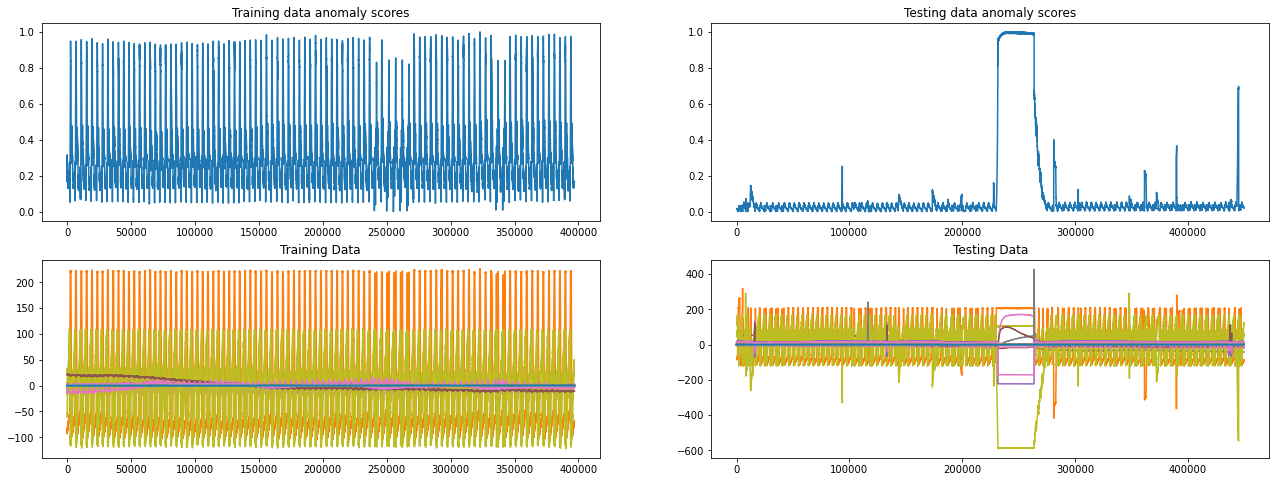

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize =(22, 8))

ax1.plot(train_scores)
ax1.set_title("Training data anomaly scores")

ax2.plot(test_scores)
ax2.set_title("Testing data anomaly scores")


ax3.plot(df_train_x_norm)
ax3.set_title('Training Data')

ax4.plot(df_test_x_norm)
ax4.set_title('Testing Data')

Above we can see that there are some extremely obvious outliers in the testing data, as compared to the training data.
Next step is to define a basic linear "threshold" in the reconstruction error that we can define "anomalies" as. 

Text(0, 0.5, 'Anomaly score')

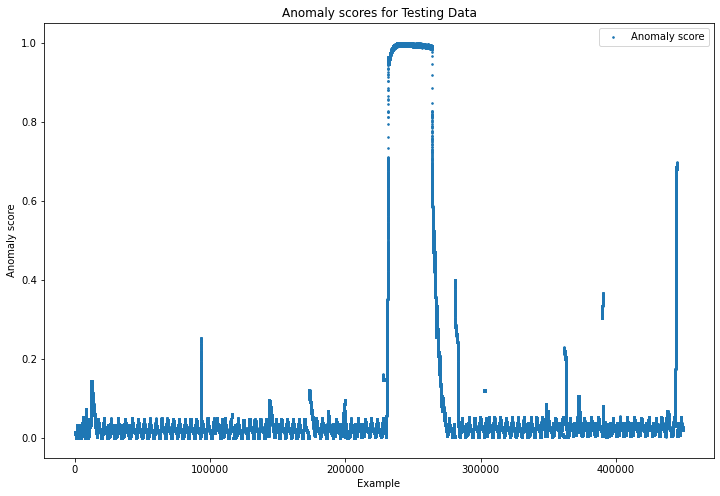

In [32]:
fig = plt.figure(figsize=(12,8))

plt.scatter(test_scores.index, test_scores.values, alpha=1, marker=".", s=10)

plt.title('Anomaly scores for Testing Data')
plt.legend(['Anomaly score'])
plt.xlabel('Example')
plt.ylabel('Anomaly score')

Above we can see that around `0.06` we see a lot of spikes in anomaly scores. Let's define the threshold as `0.06`.

## 3b. Analysis and answers to the questions

In [33]:
# Manually define TP/FP/TN/FN because we're not using a built-in predictor for this model
threshold = 0.06
detected_anoms = df_test_x.iloc[np.where(test_scores >= threshold)]
true_anoms = df_test_x.iloc[np.where(df_test_y == 0)] # 0 is attack

# True positives: the intersection of predicted anomalies and actual attacks
TP = df_test_x.iloc[pd.Index.intersection(detected_anoms.index, true_anoms.index).values]

# False positives: the intersection of predicted anomalies and non-attacks
FP = df_test_x.iloc[pd.Index.intersection(detected_anoms.index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# True negatives: The intersection of the examples underneath the threshold and non-attacks
TN = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(test_scores < threshold)].index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# False negatives: The intersection of examples underneath the threshold and actual attacks
FN = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(test_scores < threshold)].index, true_anoms.index).values]

In [34]:
precision = len(TP) / (len(TP + FP))
recall = len(TP) / (len(TP + FN))

print("True Positives:", len(TP), " | False Positives:", len(FP), " | True Negatives:", len(TN), " | False Negatives:", len(FN))
print("[Precision]:", precision, " - [Recall]:", recall)

True Positives: 38036  | False Positives: 20968  | True Negatives: 375051  | False Negatives: 15864
[Precision]: 0.6446342620839265  - [Recall]: 0.7056771799628943


Text(0, 0.5, 'Anomaly score')

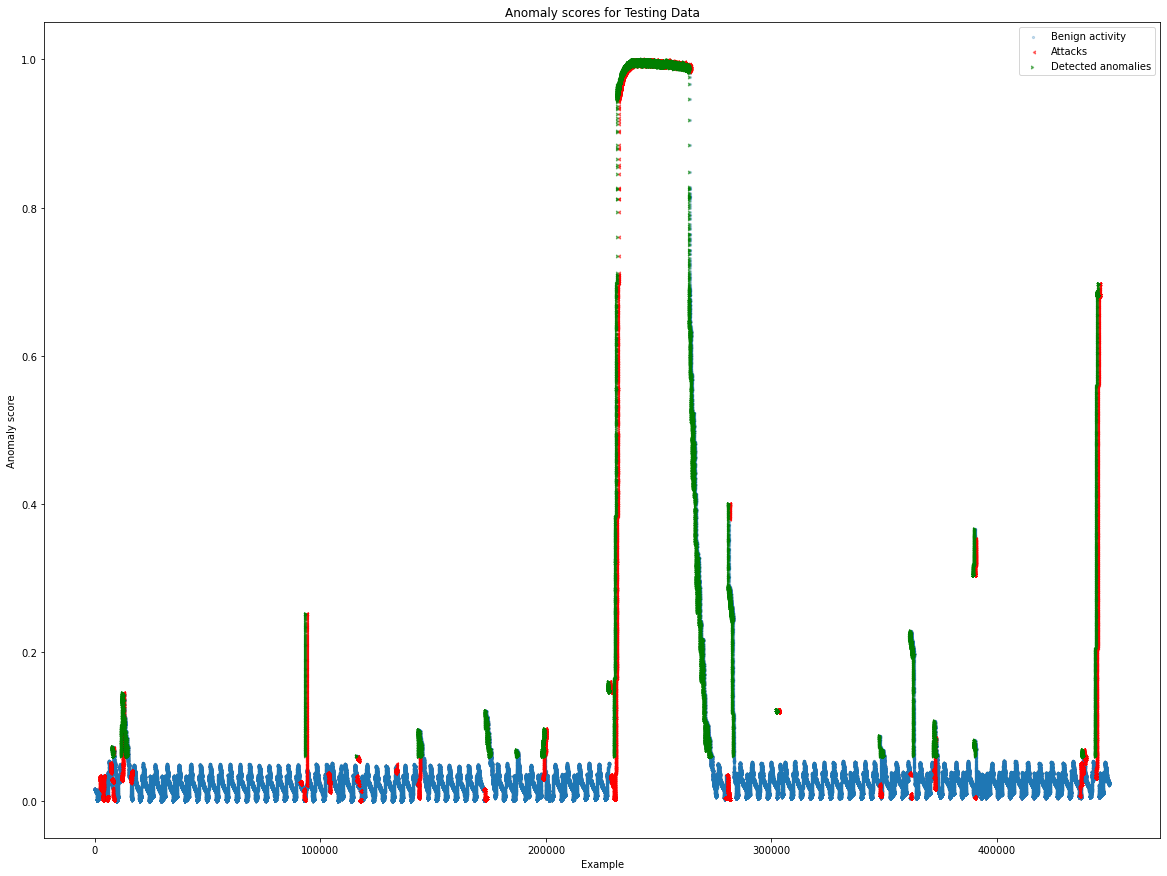

In [35]:
fig = plt.figure(figsize=(20,15))


# Benign data
plt.scatter(test_scores.loc[df_test_y == 1].index, test_scores.loc[df_test_y == 1].values, marker="o", alpha=0.25, s=5)

# Attacks
plt.scatter(true_anoms.index, test_scores.iloc[true_anoms.index], color='r', alpha=0.5, marker=4, s=10)

# Detected anomalies
plt.scatter(detected_anoms.index, test_scores.iloc[detected_anoms.index].values, color='g', alpha=0.5, marker=5, s=10)



plt.title('Anomaly scores for Testing Data')
plt.legend(['Benign activity', 'Attacks', 'Detected anomalies'])
plt.xlabel('Example')
plt.ylabel('Anomaly score')

The results are decent, catching ~70% of the attacks with 64% precision. 

**What if we separate the signals into their respective feature groups?**

In [36]:
# Lower band (see visualization task above)
pca_lb = PCA(n_components=optimal_comp)

df_pca_train_lb = pd.DataFrame(pca_lb.fit_transform(df_train_x_norm[lower_band]))
df_pca_test_lb = pd.DataFrame(pca_lb.fit_transform(df_test_x_norm[lower_band]))

pca_inverse_train_lb = pd.DataFrame(pca_lb.inverse_transform(df_pca_train_lb), columns=df_train_x_norm[lower_band].columns)
pca_inverse_test_lb = pd.DataFrame(pca_lb.inverse_transform(df_pca_test_lb), columns=df_train_x_norm[lower_band].columns)

train_scores_lb = anomalyScores(df_train_x_norm[lower_band], pca_inverse_train_lb)
test_scores_lb = anomalyScores(df_test_x_norm[lower_band], pca_inverse_test_lb)

In [37]:
# Set the lower threshold band for 0.06, slightly above where most of the anomaly scores are grouped
threshold_lb = 0.06
detected_anoms_lb = df_test_x[lower_band].iloc[np.where(test_scores >= threshold_lb)]
true_anoms_lb = df_test_x[lower_band].iloc[np.where(df_test_y == 0)] # 0 is attack

# True positives: the intersection of predicted anomalies and actual attacks
TP_lb = df_test_x.iloc[pd.Index.intersection(detected_anoms_lb.index, true_anoms_lb.index).values]

# False positives: the intersection of predicted anomalies and non-attacks
FP_lb = df_test_x.iloc[pd.Index.intersection(detected_anoms_lb.index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# True negatives: The intersection of the examples underneath the threshold and non-attacks
TN_lb = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(test_scores < threshold_lb)].index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# False negatives: The intersection of examples underneath the threshold and actual attacks
FN_lb = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(test_scores < threshold_lb)].index, true_anoms_lb.index).values]

precision_lb = len(TP_lb) / (len(TP_lb + FP_lb))
recall_lb = len(TP_lb) / (len(TP_lb + FN_lb))

print("True Positives:", len(TP_lb), " | False Positives:", len(FP_lb), " | True Negatives:", len(TN_lb), " | False Negatives:", len(FN_lb))
print("[Precision]:", precision_lb, " - [Recall]:", recall_lb)

True Positives: 38036  | False Positives: 20968  | True Negatives: 375051  | False Negatives: 15864
[Precision]: 0.6446342620839265  - [Recall]: 0.7056771799628943


Text(0.5, 1.0, 'Testing Data [lower_band]')

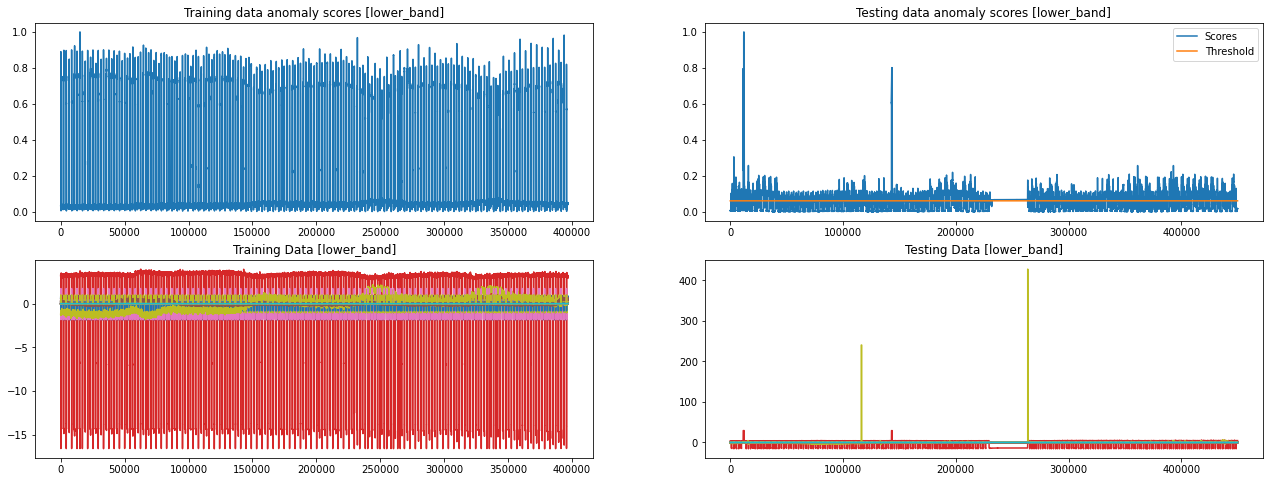

In [38]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize =(22, 8))

ax1.plot(train_scores_lb)
ax1.set_title("Training data anomaly scores [lower_band]")

t_lb = pd.Series(data=threshold_lb, index=test_scores_lb.index)
ax2.plot(test_scores_lb)
ax2.plot(t_lb)
ax2.set_title("Testing data anomaly scores [lower_band]")
ax2.legend(['Scores', 'Threshold'])



ax3.plot(df_train_x_norm[lower_band])
ax3.set_title('Training Data [lower_band]')

ax4.plot(df_test_x_norm[lower_band])
ax4.set_title('Testing Data [lower_band]')

In [39]:
# Middle band
pca_mb = PCA(n_components=optimal_comp)

df_pca_train_mb = pd.DataFrame(pca_mb.fit_transform(np.abs(df_train_x_norm[middle_band])))
df_pca_test_mb = pd.DataFrame(pca_mb.fit_transform(np.abs(df_test_x_norm[middle_band])))

pca_inverse_train_mb = pd.DataFrame(pca_mb.inverse_transform(df_pca_train_mb), columns=df_train_x_norm[middle_band].columns)
pca_inverse_test_mb = pd.DataFrame(pca_mb.inverse_transform(df_pca_test_mb), columns=df_train_x_norm[middle_band].columns)

train_scores_mb = anomalyScores(df_train_x_norm[middle_band], pca_inverse_train_mb)
test_scores_mb = anomalyScores(df_test_x_norm[middle_band], pca_inverse_test_mb)

In [40]:
# Set the middle band threshold around 0.05
threshold_mb = 0.05
detected_anoms_mb = df_test_x[middle_band].iloc[np.where(test_scores >= threshold_mb)]
true_anoms_mb = df_test_x[middle_band].iloc[np.where(df_test_y == 0)] # 0 is attack

# True positives: the intersection of predicted anomalies and actual attacks
TP_mb = df_test_x.iloc[pd.Index.intersection(detected_anoms_mb.index, true_anoms_mb.index).values]

# False positives: the intersection of predicted anomalies and non-attacks
FP_mb = df_test_x.iloc[pd.Index.intersection(detected_anoms_mb.index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# True negatives: The intersection of the examples underneath the threshold and non-attacks
TN_mb = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(test_scores < threshold_mb)].index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# False negatives: The intersection of examples underneath the threshold and actual attacks
FN_mb = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(test_scores < threshold_mb)].index, true_anoms_mb.index).values]

precision_mb = len(TP_mb) / (len(TP_mb + FP_mb))
recall_mb = len(TP_mb) / (len(TP_mb + FN_mb))

print("True Positives:", len(TP_mb), " | False Positives:", len(FP_mb), " | True Negatives:", len(TN_mb), " | False Negatives:", len(FN_mb))
print("[Precision]:", precision_mb, " - [Recall]:", recall_mb)

True Positives: 39209  | False Positives: 26523  | True Negatives: 369496  | False Negatives: 14691
[Precision]: 0.5964979005659344  - [Recall]: 0.7274397031539889


Text(0.5, 1.0, 'Testing Data [middle_band]')

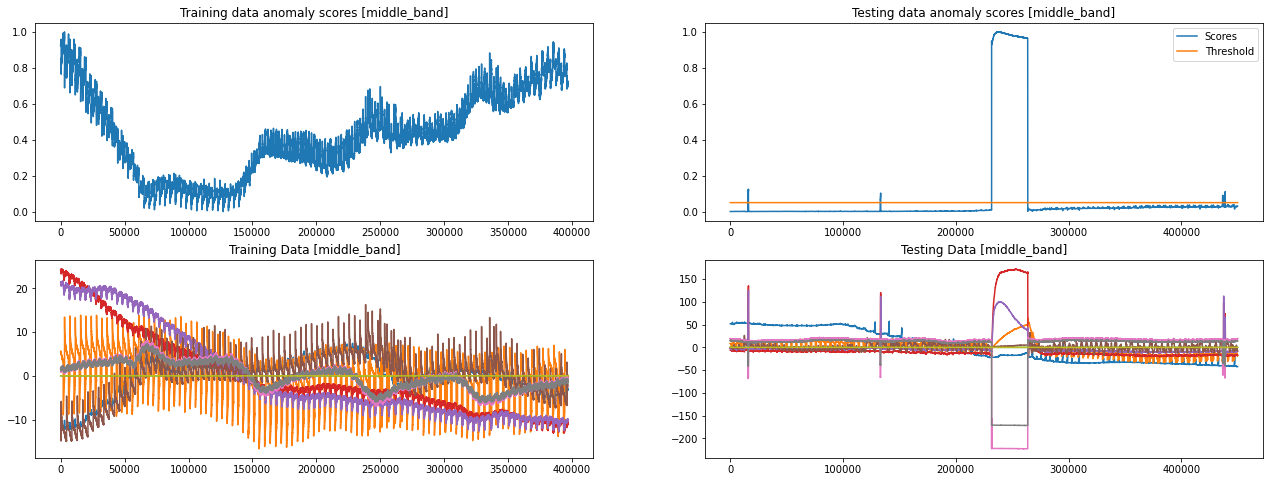

In [41]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize =(22, 8))

ax1.plot(train_scores_mb)
ax1.set_title("Training data anomaly scores [middle_band]")

t_mb = pd.Series(data=threshold_mb, index=test_scores_mb.index)
ax2.plot(test_scores_mb)
ax2.plot(t_mb)
ax2.set_title("Testing data anomaly scores [middle_band]")
ax2.legend(['Scores', 'Threshold'])



ax3.plot(df_train_x_norm[middle_band])
ax3.set_title('Training Data [middle_band]')

ax4.plot(df_test_x_norm[middle_band])
ax4.set_title('Testing Data [middle_band]')

In [42]:
# Upper band
pca_ub = PCA(n_components=2) # 2 components because there's only 3 attributes

df_pca_train_ub = pd.DataFrame(pca_ub.fit_transform(np.abs(df_train_x_norm[upper_band])))
df_pca_test_ub = pd.DataFrame(pca_ub.fit_transform(np.abs(df_test_x_norm[upper_band])))

pca_inverse_train_ub = pd.DataFrame(pca_ub.inverse_transform(df_pca_train_ub), columns=df_train_x_norm[upper_band].columns)
pca_inverse_test_ub = pd.DataFrame(pca_ub.inverse_transform(df_pca_test_ub), columns=df_train_x_norm[upper_band].columns)

train_scores_ub = anomalyScores(df_train_x_norm[upper_band], pca_inverse_train_ub)
test_scores_ub = anomalyScores(df_test_x_norm[upper_band], pca_inverse_test_ub)

In [43]:
# Set the middle band threshold around 0.07
threshold_ub = 0.07
detected_anoms_ub = df_test_x[upper_band].iloc[np.where(test_scores >= threshold_ub)]
true_anoms_ub = df_test_x[upper_band].iloc[np.where(df_test_y == 0)] # 0 is attack

# True positives: the intersection of predicted anomalies and actual attacks
TP_ub = df_test_x.iloc[pd.Index.intersection(detected_anoms_ub.index, true_anoms_ub.index).values]

# False positives: the intersection of predicted anomalies and non-attacks
FP_ub = df_test_x.iloc[pd.Index.intersection(detected_anoms_ub.index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# True negatives: The intersection of the examples underneath the threshold and non-attacks
TN_ub = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(test_scores < threshold_ub)].index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# False negatives: The intersection of examples underneath the threshold and actual attacks
FN_ub = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(test_scores < threshold_ub)].index, true_anoms_ub.index).values]

precision_ub = len(TP_ub) / (len(TP_ub + FP_ub))
recall_ub = len(TP_ub) / (len(TP_ub + FN_ub))

print("True Positives:", len(TP_ub), " | False Positives:", len(FP_ub), " | True Negatives:", len(TN_ub), " | False Negatives:", len(FN_ub))
print("[Precision]:", precision_ub, " - [Recall]:", recall_ub)

True Positives: 37157  | False Positives: 18290  | True Negatives: 377729  | False Negatives: 16743
[Precision]: 0.6701354446588634  - [Recall]: 0.6893692022263451


Text(0.5, 1.0, 'Testing Data [upper_band]')

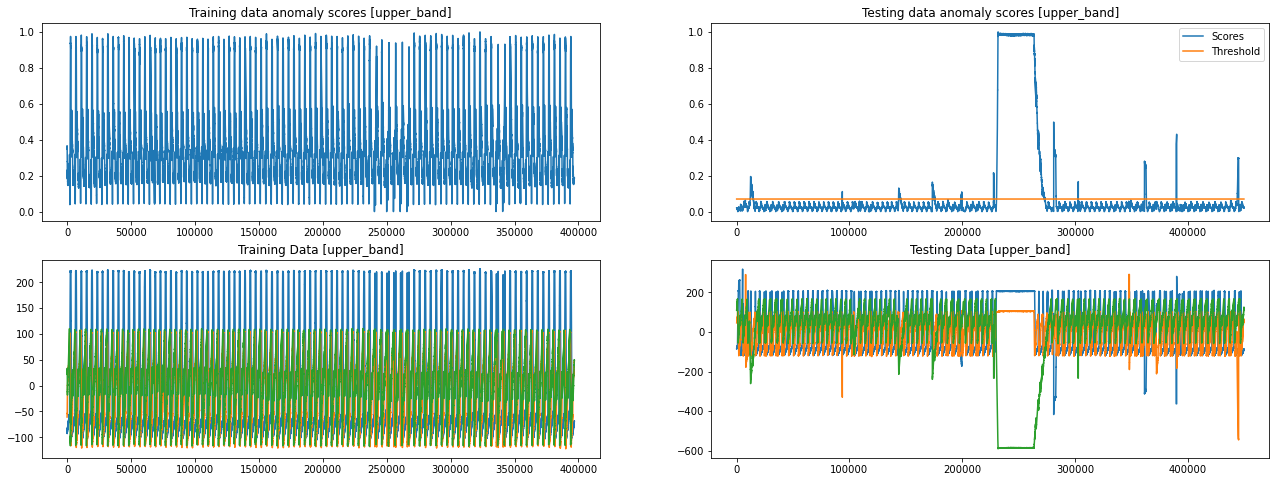

In [44]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize =(22, 8))

ax1.plot(train_scores_ub)
ax1.set_title("Training data anomaly scores [upper_band]")

t_ub = pd.Series(data=threshold_ub, index=test_scores_ub.index)
ax2.plot(test_scores_ub)
ax2.plot(t_ub)
ax2.set_title("Testing data anomaly scores [upper_band]")
ax2.legend(['Scores', 'Threshold'])


ax3.plot(df_train_x_norm[upper_band])
ax3.set_title('Training Data [upper_band]')


ax4.plot(df_test_x_norm[upper_band])
ax4.set_title('Testing Data [upper_band]')



### (4) What kind of anomalies can / can you not detect using PCA?


As you can see above, separating the signals into their respective groups didn't aid the PCA process much. On the entire dataset with the current threshold of a reconstruction error of `0.07`, we're catching about 70% of the attacks with 66% precision. This is largely due to the fact that loads of anomalies do not score a very high reconstruction error. Additionally, there are some examples that score extremely high reconstruction errors, but are not actually attacks. Therefore, a more complex scoring mechanism and/or a more complex threshold mechanism may be required to increase performance.

One of the difficulties here is that we're performing unsupervised learning - we're not able to tell the model what is and isn't an attack. A potential solution is to combine the datasets and use a supervised learning classifier model to train it on attack examples. However, we were explicitly told not to do so, so only a more complex solution might be appropriate for this.





# 4. ARMA task – 1/2 A4 - Individual


For this portion of the assignment, we need to choose 5 "different-looking" signals to perform ARMA upon. I chose the following: [`MV101`, `AIT202`, `AIT401`, `FIT101`, `P101`]

In [45]:
signals = ['MV101', 'AIT202', 'AIT401', 'FIT101', 'P101']

# Shorten the dataset significantly because ARMA models take a very long time to fit
df_signals_train = df_train_x_short[signals][:10000]
df_signals_test = df_test_x[signals][:10000]

### 4a. Print relevant plots and/or metrics to determine the parameters.

In [46]:
# from pandas.plotting import autocorrelation_plot

# autocorrelation_plot(df_signals_train.MV101)

C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


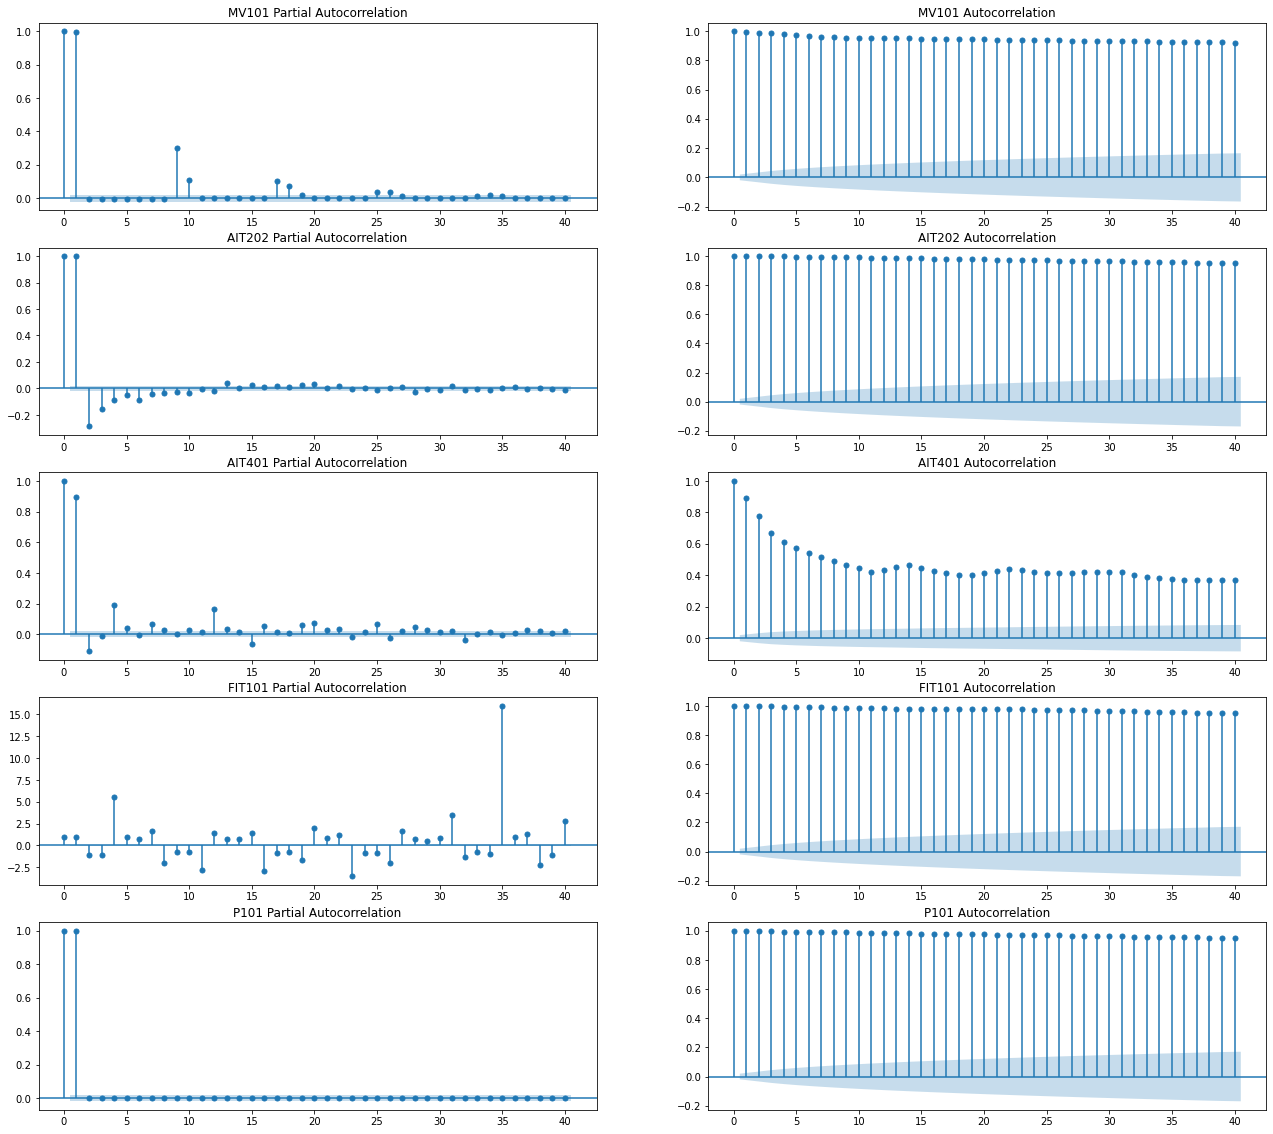

In [47]:
f, axis = plt.subplots(5,2,figsize =(22, 20))

for index, signal in enumerate(signals):
    
    # Alpha is the confidence interval, e.g. 0.05 means 95% confidence
    plot_pacf(df_signals_train[signal], alpha = 0.05, ax=axis[index][0], title=signal + " Partial Autocorrelation")
    plot_acf(df_signals_train[signal], alpha = 0.05, ax=axis[index][1], title=signal + " Autocorrelation")
    
    # Uncomment these to zoom in on the plots to better see the 95% confidence bands
#     axis[index][0].set_ylim([-0.1,0.1])
#     axis[index][1].set_ylim([-0.25,0.25])


plt.show()

From the (partial) autocorrelation plots, we can see (when zooming in via the commented code) that the order `p` values for each signal should be the number of residuals before it crosses into the 95% significance band. However, for the Autocorrelation plots (which we need to inspect for the order `q` of the MA term), **we see that literally none of the residuals enter the 95% confidence band**. This means that the signal is highly correlated to itself. Therefore, we can set the order from the partial autocorrelation equal to the order of the autocorrelation, e.g. `p = q`.

 **The `q` term tells us how many terms are required to remove any autocorrelation in the time series.** If we don't remove the autocorrelation, we can increase the `q` term.

| Signal |  p  |  q  |
|--------|-----|-----|
| MV101  |  2  |  2  |
| AIT202 |  5  |  5  |
| AIT401 |  3  |  3  |
| FIT101 |  4  |  4  |
| P101   |  2  |  2  | 

We'll define anomalies as examples that have a high reconstruction error, using the same method as before. The threshold will be the "3-sigma rule," or a threshold that is the mean of the training prediction errors plus 3 times the standard deviation.

[Threshold Source](https://becominghuman.ai/time-series-and-how-to-detect-anomalies-in-them-part-iii-f72e800e15e2)

In [48]:
def ARMA_prediction_errors(testing_data, prediction_data):
    return np.abs(testing_data - prediction_data)


def threshold(train_pred_errors):
    return np.mean(train_pred_errors) + 3 * np.std(train_pred_errors)

def get_anomalies(threshold, prediction_data):
    return pd.Series(prediction_data.loc[np.where(prediction_data > threshold)])

### 4b. Plots to study the detected anomalies

**Signal: MV101**

In [49]:
# since the package no longer supports just ARMA, we will use ARIMA where d=0

model_MV101 = ARIMA(df_signals_train.MV101, order=(2, 0, 2))
fit_model_MV101 = model_MV101.fit()
residuals_MV101 = fit_model_MV101.apply(df_test_x.MV101).resid

print(fit_model_MV101.summary())


C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  MV101   No. Observations:                10000
Model:                 ARIMA(2, 0, 2)   Log Likelihood               16909.436
Date:                Fri, 28 May 2021   AIC                         -33806.873
Time:                        23:07:16   BIC                         -33763.611
Sample:                             0   HQIC                        -33792.229
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7648      0.413      4.272      0.000       0.955       2.574
ar.L1          0.1063      0.048      2.225      0.026       0.013       0.200
ar.L2          0.8845      0.047     18.965      0.0

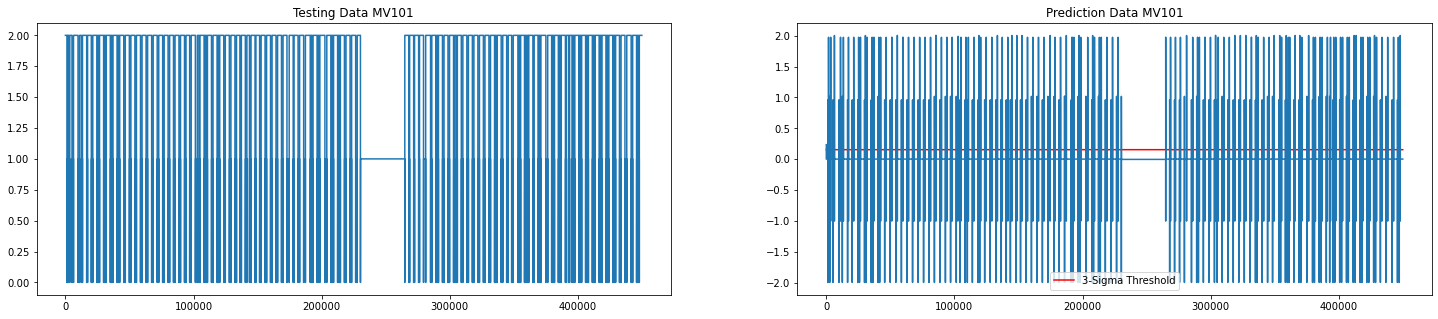

In [50]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,5))
ax1.plot(df_test_x.MV101)
ax1.set_title("Testing Data MV101")

t_MV101 = pd.Series(data=threshold(residuals_MV101), index=residuals_MV101.index)
ax2.plot(t_MV101, color='r')
ax2.plot(residuals_MV101)
ax2.set_title("Prediction Data MV101")
ax2.legend(['3-Sigma Threshold'])



In [51]:
MV101_scores = ARMA_prediction_errors(df_test_x.MV101, residuals_MV101)
threshold_MV101 = threshold(residuals_MV101)
detected_anoms_MV101 = get_anomalies(threshold_MV101, MV101_scores)

true_anoms_MV101 = df_test_x.MV101.iloc[np.where(df_test_y == 0)] # 0 is attack

# True positives: the intersection of predicted anomalies and actual attacks
TP_MV101 = df_test_x.iloc[pd.Index.intersection(detected_anoms_MV101.index, true_anoms_MV101.index).values]

# False positives: the intersection of predicted anomalies and non-attacks
FP_MV101 = df_test_x.iloc[pd.Index.intersection(detected_anoms_MV101.index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# True negatives: The intersection of the examples underneath the threshold and non-attacks
TN_MV101 = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(MV101_scores < threshold_MV101)].index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# False negatives: The intersection of examples underneath the threshold and actual attacks
FN_MV101 = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(MV101_scores < threshold_MV101)].index, true_anoms_MV101.index).values]

precision_MV101 = len(TP_MV101) / (len(TP_MV101 + FP_MV101))
recall_MV101 = len(TP_MV101) / (len(TP_MV101 + FN_MV101))

print("True Positives:", len(TP_MV101), " | False Positives:", len(FP_MV101), " | True Negatives:", len(TN_MV101), " | False Negatives:", len(FN_MV101))
print("[Precision]:", precision_MV101, " - [Recall]:", recall_MV101)



True Positives: 53807  | False Positives: 393869  | True Negatives: 2150  | False Negatives: 93
[Precision]: 0.12019183516650435  - [Recall]: 0.9982745825602969


**Signal: AIT202**

In [52]:
model_AIT202 = ARIMA(df_signals_train.AIT202, order=(5, 0, 5))
fit_model_AIT202 = model_AIT202.fit()
residuals_AIT202 = fit_model_AIT202.apply(df_test_x.AIT202).resid

print(fit_model_AIT202.summary())

C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 AIT202   No. Observations:                10000
Model:                 ARIMA(5, 0, 5)   Log Likelihood               57748.861
Date:                Fri, 28 May 2021   AIC                        -115473.721
Time:                        23:07:39   BIC                        -115387.197
Sample:                             0   HQIC                       -115444.433
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3546      0.010    829.367      0.000       8.335       8.374
ar.L1          1.8108      0.003    638.421      0.000       1.805       1.816
ar.L2         -0.1866      0.004    -50.124      0.0

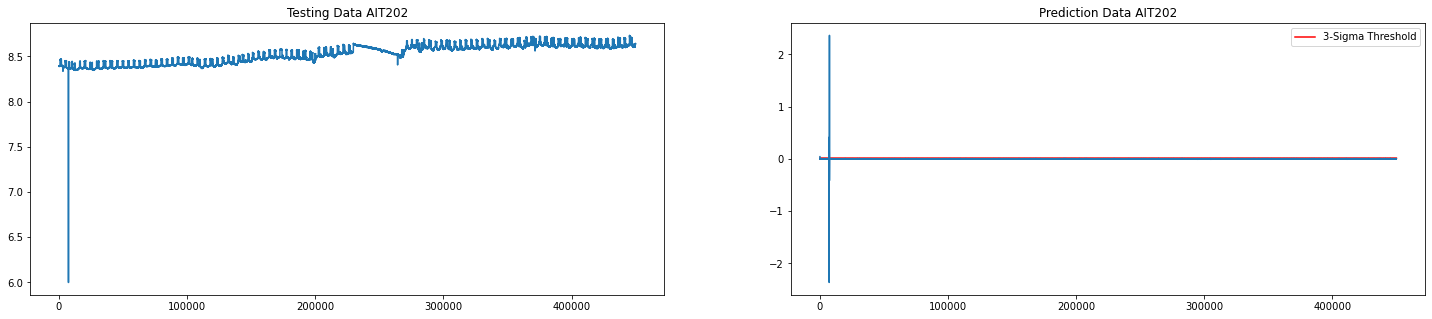

In [53]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,5))
ax1.plot(df_test_x.AIT202)
ax1.set_title("Testing Data AIT202")


t_AIT202 = pd.Series(data=threshold(residuals_AIT202), index=residuals_AIT202.index)
ax2.plot(t_AIT202, color='r')


ax2.plot(residuals_AIT202)
ax2.set_title("Prediction Data AIT202")
ax2.legend(['3-Sigma Threshold'])

In [54]:
AIT202_scores = ARMA_prediction_errors(df_test_x.AIT202, residuals_AIT202)
threshold_AIT202 = threshold(residuals_AIT202)
detected_anoms_AIT202 = get_anomalies(threshold_AIT202, AIT202_scores)

true_anoms_AIT202 = df_test_x.AIT202.iloc[np.where(df_test_y == 0)] # 0 is attack

# True positives: the intersection of predicted anomalies and actual attacks
TP_AIT202 = df_test_x.iloc[pd.Index.intersection(detected_anoms_AIT202.index, true_anoms_AIT202.index).values]

# False positives: the intersection of predicted anomalies and non-attacks
FP_AIT202 = df_test_x.iloc[pd.Index.intersection(detected_anoms_AIT202.index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# True negatives: The intersection of the examples underneath the threshold and non-attacks
TN_AIT202 = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(AIT202_scores < threshold_AIT202)].index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# False negatives: The intersection of examples underneath the threshold and actual attacks
FN_AIT202 = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(AIT202_scores < threshold_AIT202)].index, true_anoms_AIT202.index).values]

precision_AIT202 = len(TP_AIT202) / (len(TP_AIT202 + FP_AIT202))
recall_AIT202 = len(TP_AIT202) / (len(TP_AIT202 + FN_AIT202))

print("True Positives:", len(TP_AIT202), " | False Positives:", len(FP_AIT202), " | True Negatives:", len(TN_AIT202), " | False Negatives:", len(FN_AIT202))
print("[Precision]:", precision_AIT202, " - [Recall]:", recall_AIT202)



True Positives: 53900  | False Positives: 396019  | True Negatives: 0  | False Negatives: 0
[Precision]: 0.11979934165927644  - [Recall]: 1.0


**Signal: AIT401**

In [55]:
model_AIT401 = ARIMA(df_signals_train.AIT401, order=(3, 0, 3))
fit_model_AIT401 = model_AIT401.fit()
residuals_AIT401 = fit_model_AIT401.apply(df_test_x.AIT401).resid

print(fit_model_AIT401.summary())

C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 AIT401   No. Observations:                10000
Model:                 ARIMA(3, 0, 3)   Log Likelihood               52597.478
Date:                Fri, 28 May 2021   AIC                        -105178.956
Time:                        23:07:59   BIC                        -105121.273
Sample:                             0   HQIC                       -105159.430
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        148.8069      0.000   6.96e+05      0.000     148.807     148.807
ar.L1          1.3227      0.013    104.135      0.000       1.298       1.348
ar.L2         -0.4295      0.022    -19.674      0.0

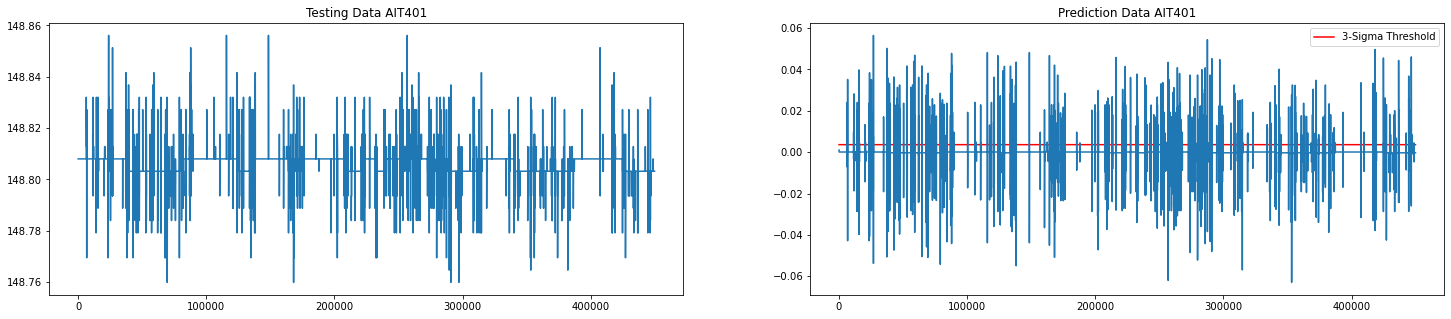

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,5))

ax1.plot(df_test_x.AIT401)
ax1.set_title("Testing Data AIT401")

t_AIT401 = pd.Series(data=threshold(residuals_AIT401), index=residuals_AIT401.index)
ax2.plot(t_AIT401, color='r')

ax2.plot(residuals_AIT401)
ax2.set_title("Prediction Data AIT401")
ax2.legend(['3-Sigma Threshold'])

In [57]:
AIT401_scores = ARMA_prediction_errors(df_test_x.AIT401, residuals_AIT401)
threshold_AIT401 = threshold(residuals_AIT401)
detected_anoms_AIT401 = get_anomalies(threshold_AIT401, AIT401_scores)

true_anoms_AIT401 = df_test_x.AIT401.iloc[np.where(df_test_y == 0)] # 0 is attack

# True positives: the intersection of predicted anomalies and actual attacks
TP_AIT401 = df_test_x.iloc[pd.Index.intersection(detected_anoms_AIT401.index, true_anoms_AIT401.index).values]

# False positives: the intersection of predicted anomalies and non-attacks
FP_AIT401 = df_test_x.iloc[pd.Index.intersection(detected_anoms_AIT401.index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# True negatives: The intersection of the examples underneath the threshold and non-attacks
TN_AIT401 = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(AIT401_scores < threshold_AIT401)].index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# False negatives: The intersection of examples underneath the threshold and actual attacks
FN_AIT401 = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(AIT401_scores < threshold_AIT401)].index, true_anoms_AIT401.index).values]

precision_AIT401 = len(TP_AIT401) / (len(TP_AIT401 + FP_AIT401))
recall_AIT401 = len(TP_AIT401) / (len(TP_AIT401 + FN_AIT401))

print("True Positives:", len(TP_AIT401), " | False Positives:", len(FP_AIT401), " | True Negatives:", len(TN_AIT401), " | False Negatives:", len(FN_AIT401))
print("[Precision]:", precision_AIT401, " - [Recall]:", recall_AIT401)



True Positives: 53900  | False Positives: 396019  | True Negatives: 0  | False Negatives: 0
[Precision]: 0.11979934165927644  - [Recall]: 1.0


**Signal: FIT101**

In [58]:
model_FIT101 = ARIMA(df_signals_train.FIT101, order=(4, 0, 4))
fit_model_FIT101 = model_FIT101.fit()
residuals_FIT101 = fit_model_FIT101.apply(df_test_x.FIT101).resid

print(fit_model_FIT101.summary())


                               SARIMAX Results                                
Dep. Variable:                 FIT101   No. Observations:                10000
Model:                 ARIMA(4, 0, 4)   Log Likelihood               29640.000
Date:                Fri, 28 May 2021   AIC                         -59260.001
Time:                        23:08:13   BIC                         -59187.897
Sample:                             0   HQIC                        -59235.594
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9468      0.494      3.944      0.000       0.979       2.914
ar.L1          2.1804      0.042     51.652      0.000       2.098       2.263
ar.L2         -1.1727      0.117    -10.043      0.0

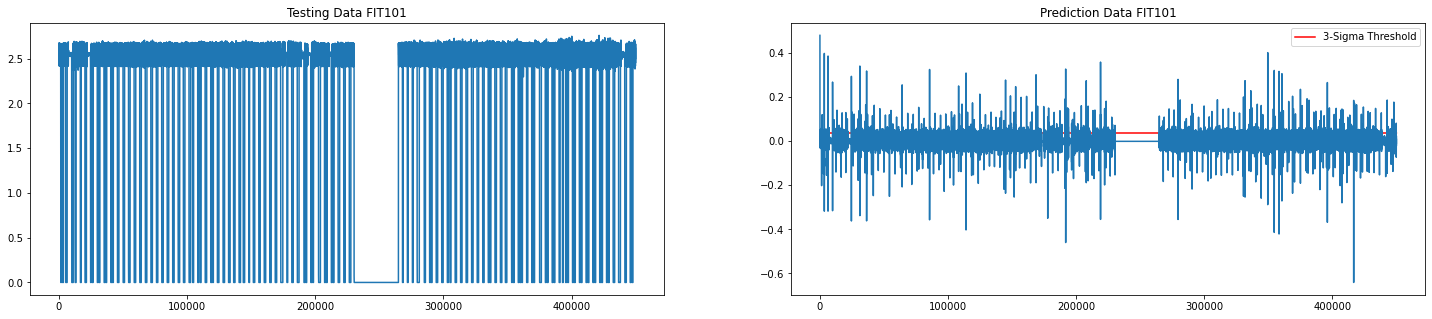

In [59]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,5))
ax1.plot(df_test_x.FIT101)
ax1.set_title("Testing Data FIT101")

t_FIT101 = pd.Series(data=threshold(residuals_FIT101), index=residuals_FIT101.index)
ax2.plot(t_FIT101, color='r')


ax2.plot(residuals_FIT101)
ax2.set_title("Prediction Data FIT101")
ax2.legend(['3-Sigma Threshold'])

In [60]:
FIT101_scores = ARMA_prediction_errors(df_test_x.FIT101, residuals_FIT101)
threshold_FIT101 = threshold(residuals_FIT101)
detected_anoms_FIT101 = get_anomalies(threshold_FIT101, FIT101_scores)

true_anoms_FIT101 = df_test_x.FIT101.iloc[np.where(df_test_y == 0)] # 0 is attack

# True positives: the intersection of predicted anomalies and actual attacks
TP_FIT101 = df_test_x.iloc[pd.Index.intersection(detected_anoms_FIT101.index, true_anoms_FIT101.index).values]

# False positives: the intersection of predicted anomalies and non-attacks
FP_FIT101 = df_test_x.iloc[pd.Index.intersection(detected_anoms_FIT101.index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# True negatives: The intersection of the examples underneath the threshold and non-attacks
TN_FIT101 = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(FIT101_scores < threshold_FIT101)].index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# False negatives: The intersection of examples underneath the threshold and actual attacks
FN_FIT101 = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(FIT101_scores < threshold_FIT101)].index, true_anoms_FIT101.index).values]

precision_FIT101 = len(TP_FIT101) / (len(TP_FIT101 + FP_FIT101))
recall_FIT101 = len(TP_FIT101) / (len(TP_FIT101 + FN_FIT101))

print("True Positives:", len(TP_FIT101), " | False Positives:", len(FP_FIT101), " | True Negatives:", len(TN_FIT101), " | False Negatives:", len(FN_FIT101))
print("[Precision]:", precision_FIT101, " - [Recall]:", recall_FIT101)



True Positives: 16267  | False Positives: 288346  | True Negatives: 107673  | False Negatives: 37633
[Precision]: 0.05340218572418117  - [Recall]: 0.3017996289424861


**Signal: P101**

In [61]:
model_P101 = ARIMA(df_signals_train.P101, order=(2, 0, 2))
fit_model_P101 = model_P101.fit()
residuals_P101 = fit_model_P101.apply(df_test_x.P101).resid

print(fit_model_P101.summary())

C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                   P101   No. Observations:                10000
Model:                 ARIMA(2, 0, 2)   Log Likelihood               24910.230
Date:                Fri, 28 May 2021   AIC                         -49808.460
Time:                        23:08:32   BIC                         -49765.198
Sample:                             0   HQIC                        -49793.816
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8124   1.76e-09   1.03e+09      0.000       1.812       1.812
ar.L1          0.0005      0.009      0.055      0.956      -0.017       0.017
ar.L2          0.9995      0.009    115.058      0.0

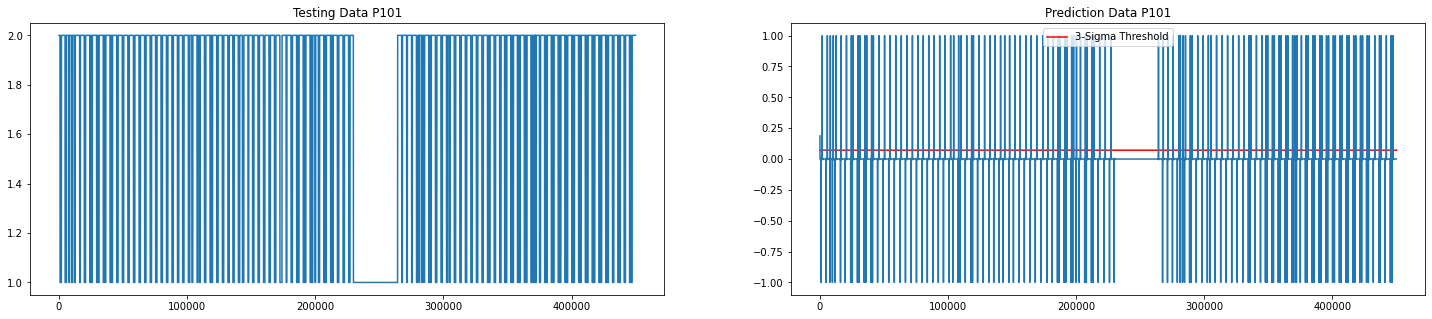

In [62]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,5))
ax1.plot(df_test_x.P101)
ax1.set_title("Testing Data P101")

t_P101 = pd.Series(data=threshold(residuals_P101), index=residuals_P101.index)
ax2.plot(t_P101, color='r')

ax2.plot(residuals_P101)
ax2.set_title("Prediction Data P101")
ax2.legend(['3-Sigma Threshold'])

In [63]:
P101_scores = ARMA_prediction_errors(df_test_x.P101, residuals_P101)
threshold_P101 = threshold(residuals_P101)
detected_anoms_P101 = get_anomalies(threshold_P101, P101_scores)

true_anoms_P101 = df_test_x.P101.iloc[np.where(df_test_y == 0)] # 0 is attack

# True positives: the intersection of predicted anomalies and actual attacks
TP_P101 = df_test_x.iloc[pd.Index.intersection(detected_anoms_P101.index, true_anoms_P101.index).values]

# False positives: the intersection of predicted anomalies and non-attacks
FP_P101 = df_test_x.iloc[pd.Index.intersection(detected_anoms_P101.index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# True negatives: The intersection of the examples underneath the threshold and non-attacks
TN_P101 = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(P101_scores < threshold_P101)].index, df_test_x.iloc[np.where(df_test_y == 1)].index).values]

# False negatives: The intersection of examples underneath the threshold and actual attacks
FN_P101 = df_test_x.iloc[pd.Index.intersection(df_test_x.iloc[np.where(P101_scores < threshold_P101)].index, true_anoms_P101.index).values]

precision_P101 = len(TP_P101) / (len(TP_P101 + FP_P101))
recall_P101 = len(TP_P101) / (len(TP_P101 + FN_P101))

print("True Positives:", len(TP_P101), " | False Positives:", len(FP_P101), " | True Negatives:", len(TN_P101), " | False Negatives:", len(FN_P101))
print("[Precision]:", precision_P101, " - [Recall]:", recall_P101)



True Positives: 53900  | False Positives: 396019  | True Negatives: 0  | False Negatives: 0
[Precision]: 0.11979934165927644  - [Recall]: 1.0


... and we're back to 10% precision and 100% recall. The ARMA model appears to require significant tuning, which I would love to do if I hadn't already spent close to 60 hours on this assignment. Dealing with Statsmodels has taken at least 20 hours of my time, dealing with bugs, and the deadline is almost here.

**Note to reviewers/graders: If I had more time, I would continue to tune the above models by inspecting the .summary() reports, identify __insignificant__ MA constants (e.g. those with P values > 0.05) and then retrain the model.** 

### 4c. Analysis and answers to the questions

- What kind of anomalies can you (not) predict using ARMA models?
    - Based on everything that I've read about ARMA models, anomalies that lie well outside the trend and seasonality (if applicable) of the data are much easier to detect than those that lie within the visible trend.

- Which sensors can be modeled effectively using ARMA?
    - ARMA models require quite a bit of feature engineering, it seems, and features that are highly correlated to themselves seem to perform the poorest. For example, the only signal that didn't have laughable performance was `FIT101`, which was the only signal of the 5 chosen that didn't have an absurd autocorrelation plot.
   

## 5. N-gram task – 1/2 A4 - Individual

### 5a. Visualise discretization

### 5b. Analysis and answers to the questions. Also provide relevant plots.

## 6.Comparision task 1 A4 - Individual

### 6a. Use the given guidelines and provide a comparision of the above implemented methods.

We will use pointwise precision/recall comparison between each of the models.

In [64]:
models = ['PCA_full','PCA_upper','PCA_middle','PCA_lower','ARMA_MV101','ARMA_AIT202','ARMA_AIT401','ARMA_FIT101','ARMA_P101','LOF','Ngram']
index = ['Precision', 'Recall']


model_results = pd.DataFrame(index = index, columns = models)

model_results.PCA_full = [precision, recall]
model_results.PCA_upper = [precision_ub, recall_ub]
model_results.PCA_middle = [precision_mb, recall_mb]
model_results.PCA_lower = [precision_lb, recall_lb]
model_results.ARMA_MV101 = [precision_MV101, recall_MV101]
model_results.ARMA_AIT202 = [precision_AIT202 , recall_AIT202]
model_results.ARMA_AIT401 = [precision_AIT401 , recall_AIT401]
model_results.ARMA_FIT101 = [precision_FIT101 , recall_FIT101]
model_results.ARMA_P101 = [precision_P101 , recall_P101]
# model_results.LOF = []
# model_results.Ngram = [] 


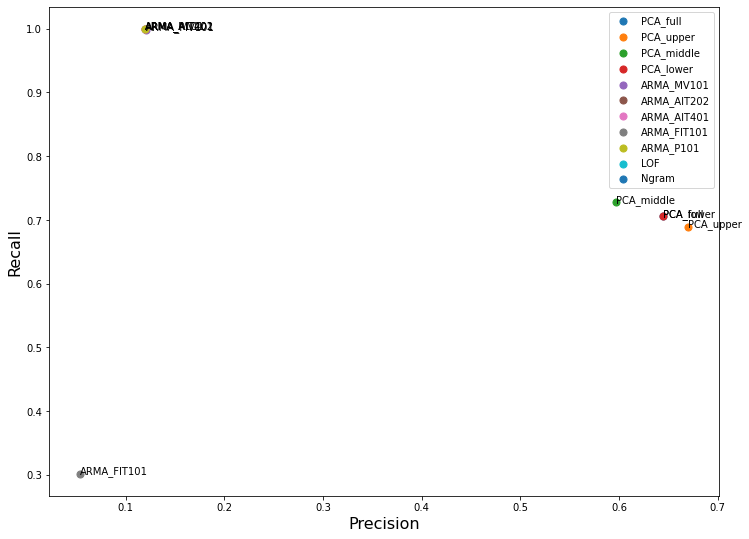

In [65]:
fig, (ax) = plt.subplots(1, figsize=(12,9))


for col in model_results.columns:
    ax.scatter(model_results[col][0], model_results[col][1], s=50)
    ax.annotate(col, (model_results[col][0], model_results[col][1]))
    
ax.set_xlabel('Precision', size=16)
ax.set_ylabel('Recall', size=16)
ax.legend(model_results.columns)



The annotation overlap is a bit annoying, but the cluster of points with recall = 1.0 are all of the ARMA models, with the exception of the model for signal `FIT101`. As we can see above, the ARMA models score extremely poorly as the 3-sigma threshold is not nearly wide enough to detect anomalies. Furthermore, the ARMA models themselves are quite pathetic and require significant tuning. 

The LOF model took a while to figure out, further compounded by deepnote crashing frequently, combined with resource constraints on my local machine, but eventually I was able to get something workable. Fitting on the test data was more complicated than expected, since the scikit-learn implementation of LOF has weird restrictions. If we want the model to predict based on new and unseen test data, we have to set the `novelty` parameter to true which then means we cannot use `fit_predict`, rather we are restricted to just `predict`. However, the actual training of the LOF had `novelty` set to false (which is default), so that caused some confusion and a lot of time trying to figure out how to fit it on the unseen test data. Based on what was already done however, this is what we have:

- quite a bit of false negatives during testing
- The decided threshold will be -2 as with this threshold about half of the hits are true anomalies which should be inspected. This is something we find acceptable as a higher ratio will probably lead to people performing the manual inspection with less quality.

We concluded that LOF can be quite useful in detecting attacks. These attacks could be both into single sensors or a combination. However, it is hard to determine which sensor(s) are causing the classifier to determine it to be an outlier. We came to this conclusion based on the comparison to ARMA which seemed particularly tough to use for this scenario.

Finally, the PCA model seems to perform decently well in terms of precision/recall *balance*, but still has a significant number of false positives. One of the more difficult things with linear/non-dynamic thresholds is that the cyclical nature of the signals means that outliers that score within the reconstruction error threshold are harder to detect. If you had a dynamic threshold, say one that is based on a sliding window, sudden jumps in reconstruction error that fall outside the mean/std/whatever of the threshold, but are still within the global 1std, could be detected.

## 7. Bonus Task 1 A4

### 7a. Provide implementation and analysis.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4178565d-6cff-47b3-ae06-02a9f2fc6608' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>